**КАКОЙ КЕЙС РЕШАЕМ?**

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

Первоначальная версия датасета содержит 17 полей со следующей информацией:
1. hotel_address — адрес отеля;
2. review_date — дата, когда рецензент разместил соответствующий отзыв;
3. average_score — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
4. hotel_name — название отеля;
5. reviewer_nationality — страна рецензента;
6. negative_review — отрицательный отзыв, который рецензент дал отелю;
7. review_total_negative_word_counts — общее количество слов в отрицательном отзыв;
8. positive_review — положительный отзыв, который рецензент дал отелю;
9. review_total_positive_word_counts — общее количество слов в положительном отзыве.\
10. reviewer_score — оценка, которую рецензент поставил отелю на основе своего опыта;
11. total_number_of_reviews_reviewer_has_given — количество отзывов, которые рецензенты дали в прошлом;
12. total_number_of_reviews — общее количество действительных отзывов об отеле;
13. tags — теги, которые рецензент дал отелю;
14. days_since_review — количество дней между датой проверки и датой очистки;
15. additional_number_of_scoring — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
16. lat — географическая широта отеля;
17. lng — географическая долгота отеля.

In [190]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # hotel processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent_analyzer = SentimentIntensityAnalyzer()

from geopy.geocoders import Nominatim
from geopy.distance import geodesic

from category_encoders import OneHotEncoder

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input hotel files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
INPUT_DIR = './data/'
import os
for dirname, _, filenames in os.walk(INPUT_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/hotels_test.csv
./data/hotels_train.csv
./data/submission.csv


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [191]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [192]:
# подгружаем данные из соревнования

# датасет для обучения
df_train = pd.read_csv(INPUT_DIR + '/hotels_train.csv')

# датасет для предсказания
df_test = pd.read_csv(INPUT_DIR + 'hotels_test.csv')

# тестовый сабмишн
sample_submission = pd.read_csv(INPUT_DIR + '/submission.csv')

In [193]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [194]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [195]:
df_test.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [196]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [197]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [198]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


In [199]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

hotel = pd.concat([df_test, df_train], sort=False).reset_index(drop=True) #объединяем

Проверим датафрейм на наличие дубликатов:

In [200]:
print(hotel.duplicated().sum())
hotel[hotel.duplicated()].groupby('hotel_name').size()

336


hotel_name
Copthorne Tara Hotel London Kensington      1
Fletcher Hotel Amsterdam                    1
H tel Baume                                50
H tel Concorde Montparnasse               235
Hotel Da Vinci                              1
Hotel Le Sainte Beuve                      35
Mercure Paris Centre Tour Eiffel            1
Park Plaza Vondelpark Amsterdam             1
Pertschy Palais Hotel                       1
The Bloomsbury Hotel                        1
Villa Eugenie                               9
dtype: int64

Дубликатов не так много и они не должны оказать большое влияние. Оставим как есть.

Разберемся с пропущенными значениями. Видим проопущенные значения только в координатах 'lat' и 'lng'. Создадим список отелей, для которых они пропущены:

In [201]:
# Создаем список отелей, для которых пропущены координаты
missing_coordinates = hotel.groupby('hotel_address').filter(lambda x: pd.isna(x['lat']).any() or pd.isna(x['lng']).any())
missing_list = list(missing_coordinates['hotel_address'].unique())
print(len(missing_list))

17


Для 17 отелей пропущены коордианты, заполним их при помощи уже при помощи библиотеки geopy. 

In [202]:
# Заполняем пропуски

# Создаем список отелей, для которых пропущены координаты
missing_coordinates = hotel.groupby('hotel_address').filter(lambda x: x['lat'].isnull().any() or x['lng'].isnull().any())
missing_list = list(missing_coordinates['hotel_address'].unique())

user_agent = "my_geocoding_app"
geolocator = Nominatim(user_agent=user_agent)

# Словарь для пропущенных значений
hotel_coordinates = {}
max_retries = 5

# Заполняем словарь координатами из geopy

for hotel_address in missing_list:
    retries = 0
    while retries < max_retries:
        # Упрощаем адрес, чтобы получить близкую координату
        location = geolocator.geocode((', '.join((hotel_address.split())[-4:])))
        if location is not None:
            hotel_coordinates[hotel_address] = [location.latitude, location.longitude]
            break
        else:
            retries += 1
            print(f'Не удалось геокодировать адрес: {hotel_address}. Попытка {retries} из {max_retries}')
    if location is None:
        hotel_coordinates[hotel_address] = [None, None]
        
print(hotel_coordinates)

{'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': [48.22507295, 16.35839764159848], 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': [48.22507295, 16.35839764159848], '23 Rue Damr mont 18th arr 75018 Paris France': [48.8870221, 2.3478318], 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': [48.2108519, 16.347359861911986], 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': [48.2006384, 16.426895311477978], 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': [48.2108519, 16.347359861911986], 'Bail n 4 6 Eixample 08010 Barcelona Spain': [41.3936885, 2.1636552], 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': [48.1914197, 16.413444086234627], '4 rue de la P pini re 8th arr 75008 Paris France': [48.8870221, 2.3478318], '20 Rue De La Ga t 14th arr 75014 Paris France': [48.8870221, 2.3478318], 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': [48.22507295, 16.35839764159848], 'Savoyenstra e 2 16 Ottakring 1160 Vienna Austria': [48.214

In [298]:
hotel_coordinates

{'W hringer Stra e 33 35 09 Alsergrund 1090 Vienna Austria': [48.22507295,
  16.35839764159848],
 'Gr nentorgasse 30 09 Alsergrund 1090 Vienna Austria': [48.22507295,
  16.35839764159848],
 '23 Rue Damr mont 18th arr 75018 Paris France': [48.8870221, 2.3478318],
 'Josefst dter Stra e 10 12 08 Josefstadt 1080 Vienna Austria': [48.2108519,
  16.347359861911986],
 'Taborstra e 8 A 02 Leopoldstadt 1020 Vienna Austria': [48.2006384,
  16.426895311477978],
 'Josefst dter Stra e 22 08 Josefstadt 1080 Vienna Austria': [48.2108519,
  16.347359861911986],
 'Bail n 4 6 Eixample 08010 Barcelona Spain': [41.3936885, 2.1636552],
 'Landstra er G rtel 5 03 Landstra e 1030 Vienna Austria': [48.1914197,
  16.413444086234627],
 '4 rue de la P pini re 8th arr 75008 Paris France': [48.8870221, 2.3478318],
 '20 Rue De La Ga t 14th arr 75014 Paris France': [48.8870221, 2.3478318],
 'W hringer Stra e 12 09 Alsergrund 1090 Vienna Austria': [48.22507295,
  16.35839764159848],
 'Savoyenstra e 2 16 Ottakring 1160

In [203]:
# Функция для замены пропущенных значений
def paste_coordiantes(row):
    if pd.isna(row['lat']) and pd.isna(row['lng']):
        address = row['hotel_address']
        row['lat'] = hotel_coordinates[address][0]
        row['lng'] = hotel_coordinates[address][1]
    return row

In [204]:
# Заполняем пропущенные значения
hotel = hotel.apply(paste_coordiantes, axis=1)

hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

Посмотрим на распределение целевой переменной:

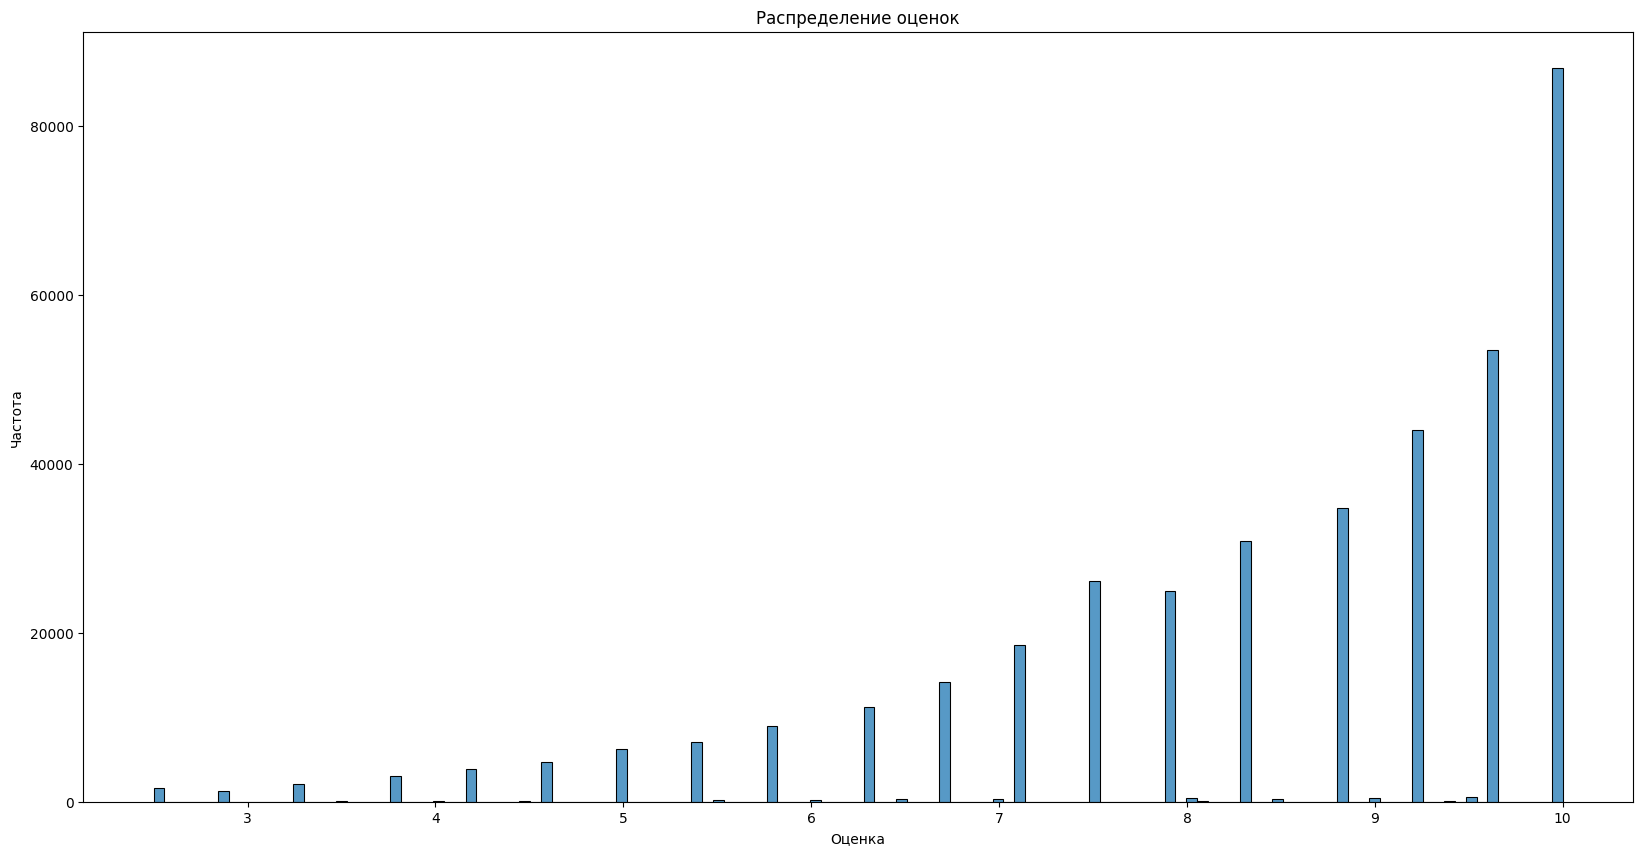

In [205]:
plt.figure(figsize=(20, 10))
sns.histplot(data=hotel[hotel['sample'] == 1], x='reviewer_score')

# Добавление заголовка и меток осей
plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Частота')

# Показ гистограммы
plt.show()

Возрастающая гистограмма указывает на смещенность данных в сторону более высоких оценок. Большинство отзывов склонны к даванию более высоких оценок, чем низких.

# Проектирование признаков

In [206]:
hotel['hotel_address'].sample(10)

498320    Kattengat 1 Amsterdam City Center 1012 SZ Amst...
224057    3 Berkeley Street Westminster Borough London W...
95802     29 31 Gower Street Camden London WC1E 6HG Unit...
472876             Aribau 54 Eixample 08011 Barcelona Spain
251637    4 18 Harrington Gardens Kensington and Chelsea...
120493    7 Pepys Street City of London London EC3N 4AF ...
244514    6 Hercules Road Lambeth London SE1 7DP United ...
200288    Via Spallanzani 40 Central Station 20129 Milan...
24490     Apollolaan 2 Oud Zuid 1077 BA Amsterdam Nether...
354349    372 Strand Westminster Borough London WC2R 0JJ...
Name: hotel_address, dtype: object

Пройдемся по каждому признаку и попробуем выделить из него дополнительную информацию. Начнем с адреса. Мы видим, что адрес содержит страну, город, индекс и сам адрес. Можем выделить страну и город:

In [207]:
hotel['country'] = hotel['hotel_address'].apply(lambda x: x.split()[-1] if x.split()[-1] != 'Kingdom' else ' '.join(x.split()[-2:]))
hotel['country'].unique()

array(['Italy', 'Netherlands', 'Spain', 'United Kingdom', 'France',
       'Austria'], dtype=object)

Всего в датасете представлено 6 стран

In [208]:
hotel['city'] = hotel['hotel_address'].apply(lambda x: x.split()[-2] if x.split()[-1] != 'Kingdom' else x.split()[-5])
hotel['city'].unique()

array(['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna'],
      dtype=object)

А в качестве городов их столицы

In [209]:
cities = list(hotel['city'].unique())
cities

['Milan', 'Amsterdam', 'Barcelona', 'London', 'Paris', 'Vienna']

Посмотрим на распределение оценок в зависимости от стран:

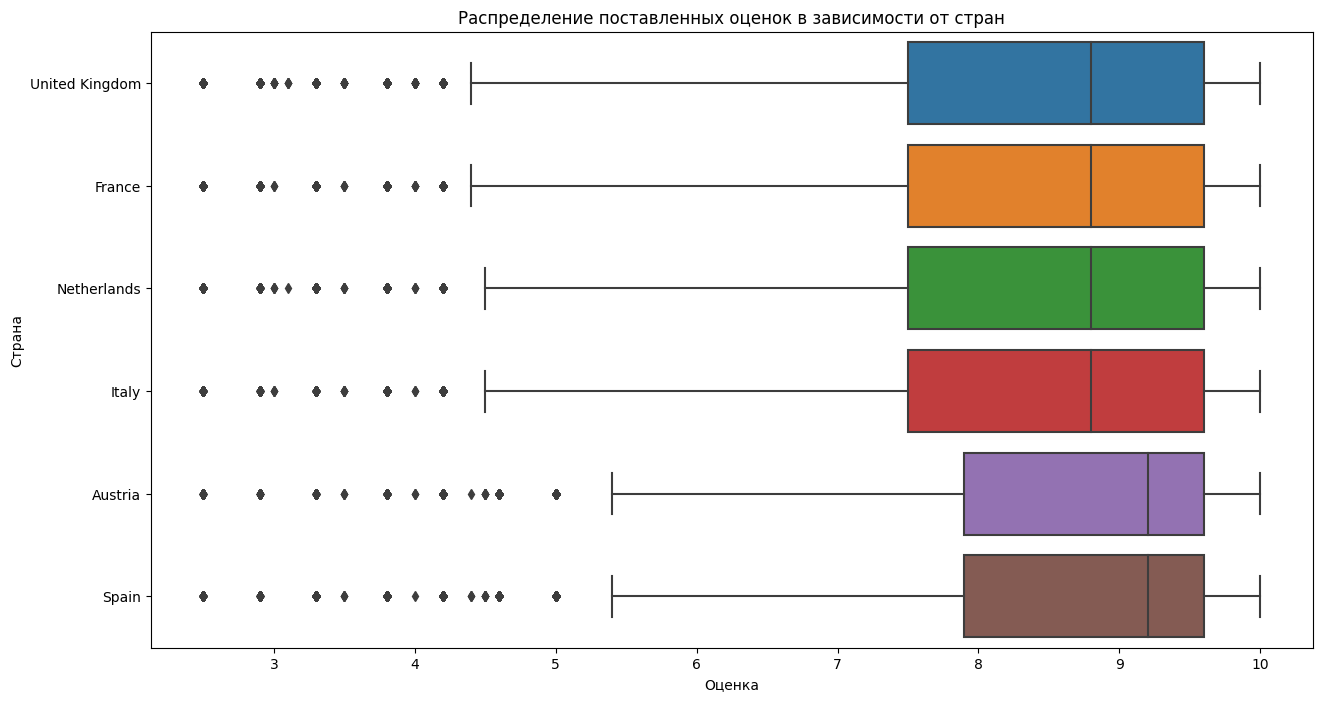

In [210]:
plt.figure(figsize=(15,8))
sns.boxplot(data=hotel[hotel['sample'] == 1], y='country', x='reviewer_score', orient='h')
plt.title('Распределение поставленных оценок в зависимости от стран')
plt.xlabel('Оценка')
plt.ylabel('Страна')
plt.show()

Видим, что для Австрии и Испании средняя оценка выше. Думаю, что страна полезный признак для обучения, а т.к. стран немного, то можно будет закодировать методом One-Hot Encoding . А из городов с помощью координат возьмем признак расстояние до центра

In [211]:
import time
center_coordinates = {}
for city in cities:
    location = geolocator.geocode(city)
    center_coordinates[city] = [location.latitude, location.longitude]
    # задержку в 1 секунду между запросами
    time.sleep(1)

In [212]:
def distance_to_center(row):
    hotel_coordinates = [row['lat'], row['lng']]
    city_center_coordinates = center_coordinates.get(row['city'])
    distance = round(geodesic(hotel_coordinates, city_center_coordinates).kilometers,1)
    return distance

In [213]:
hotel['distance_to_center'] = hotel.apply(distance_to_center, axis=1)

In [214]:
hotel['distance_to_center'].describe()

count    515738.000000
mean          3.151318
std           2.565882
min           0.000000
25%           1.400000
50%           2.500000
75%           4.100000
max          17.200000
Name: distance_to_center, dtype: float64

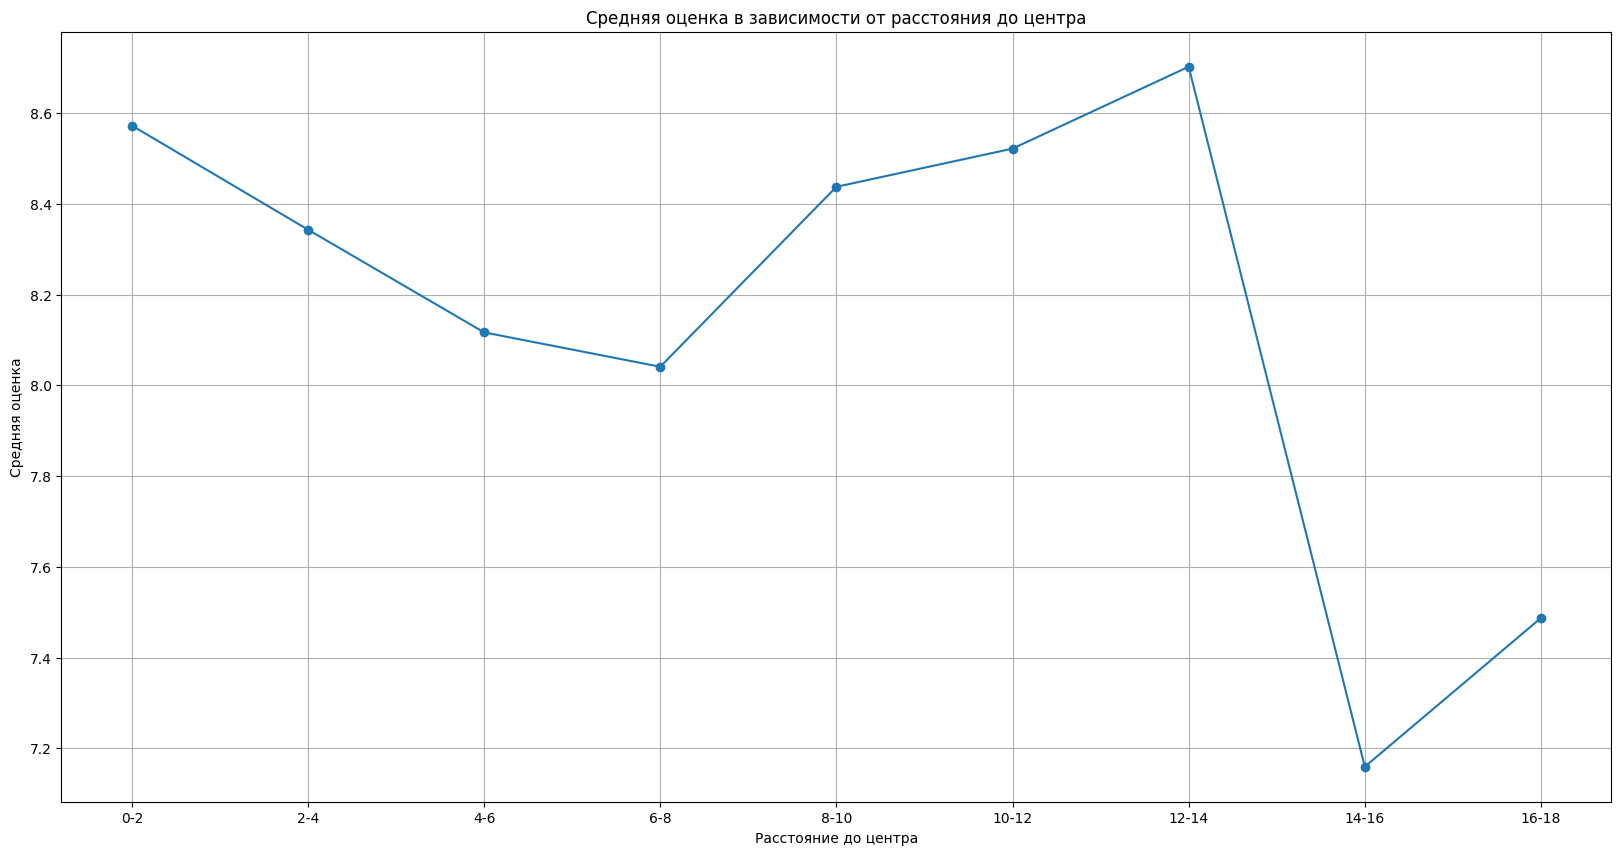

In [215]:
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]  # задаем интервалы по 2 км
labels = ['0-2', '2-4', '4-6', '6-8', '8-10','10-12', '12-14', '14-16', '16-18']  # метки для интервалов

# Группировка данных по интервалам расстояний и расчет средней оценки по каждому интервалу
fig_distance = hotel[hotel['sample'] == 1].groupby(pd.cut(hotel[hotel['sample'] == 1]['distance_to_center'], bins=bins, labels=labels))['reviewer_score'].mean().reset_index()

# Построение графика
plt.figure(figsize=(20, 10))
plt.plot(fig_distance['distance_to_center'], fig_distance['reviewer_score'], marker='o')
plt.title('Средняя оценка в зависимости от расстояния до центра')
plt.xlabel('Расстояние до центра')
plt.ylabel('Средняя оценка')
plt.grid(True)
plt.show()

По графику видно, что есть спад по мере удаления от центра, но затем снова идет рост. Возможно, ценник на на отели, которые расположены дальше от центра ниже, но условия могут быть даже лучше. Еще дальше - оценки уже ниже. Возможно уже связано с трудностями в передвижении до центра. Думаю это полезный признак для обучения.

## Дата

Информация, представленная в датах:
* Дата размещения отзыва ('review_date')
* Разница между датой отзыва и датой выгрузки данных ('days_since_review')

Рассмотрим распределение оценок по месяцам, году и кварталу:

In [216]:
hotel['review_date'] = pd.to_datetime(hotel['review_date'])
hotel['month'] = hotel['review_date'].dt.month
hotel['year'] = hotel['review_date'].dt.year
hotel['quarter'] = hotel['review_date'].dt.quarter
hotel['days_since_review'] = hotel['days_since_review'].apply(lambda x: int(x.split()[0])) # Преобразовали дни в числовое отображение

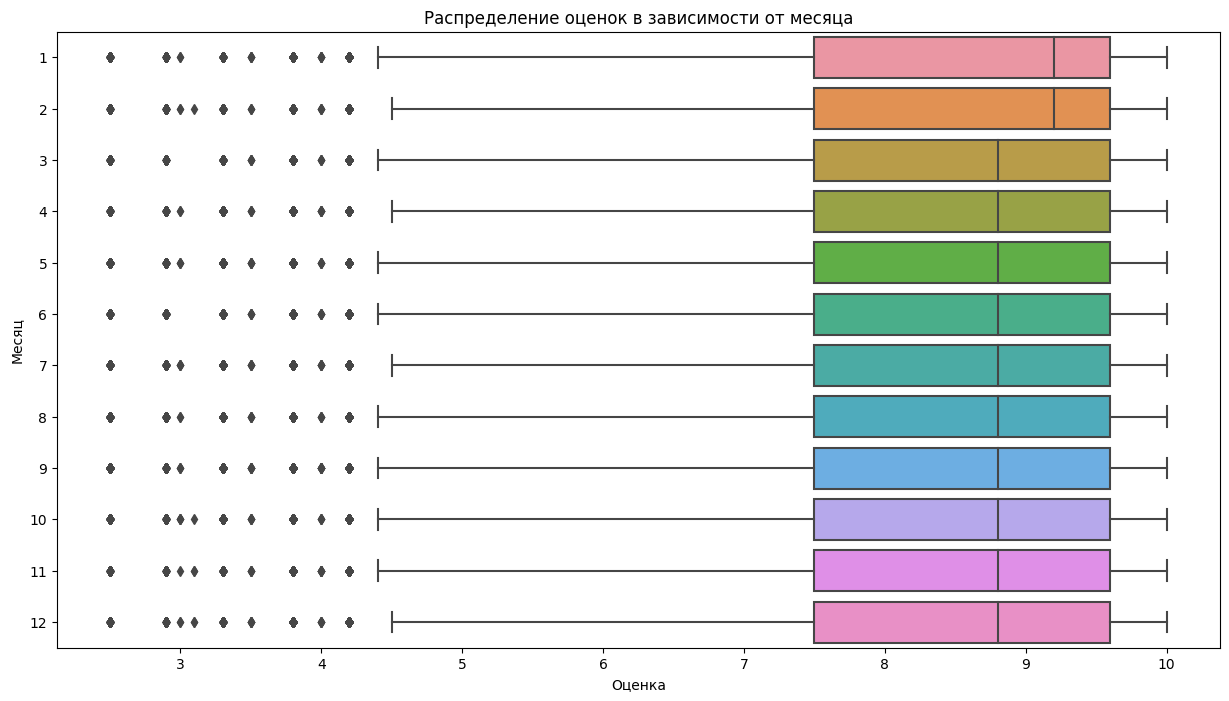

In [217]:
plt.figure(figsize=(15,8))
sns.boxplot(
    data = hotel[hotel['sample'] == 1],
    x='reviewer_score',
    y='month',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от месяца')
plt.xlabel('Оценка')
plt.ylabel('Месяц')
plt.show()

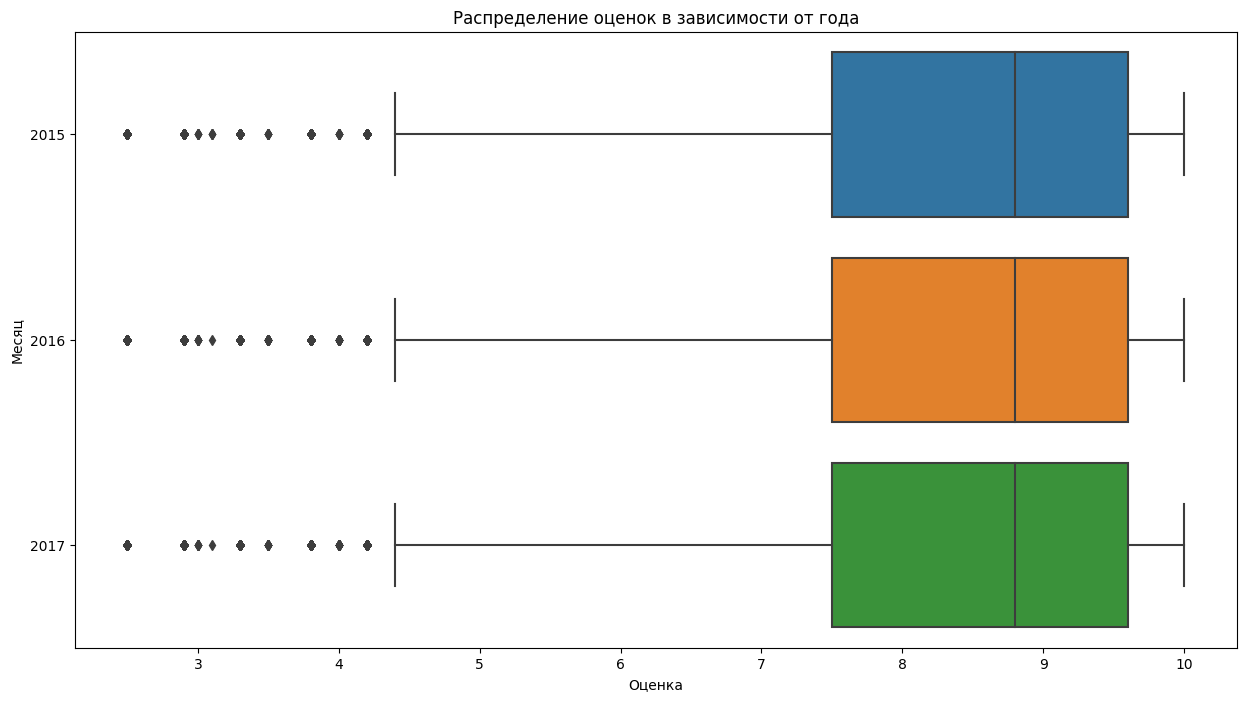

In [218]:
plt.figure(figsize=(15,8))
sns.boxplot(
    data = hotel[hotel['sample'] == 1],
    x='reviewer_score',
    y='year',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от года')
plt.xlabel('Оценка')
plt.ylabel('Месяц')
plt.show()

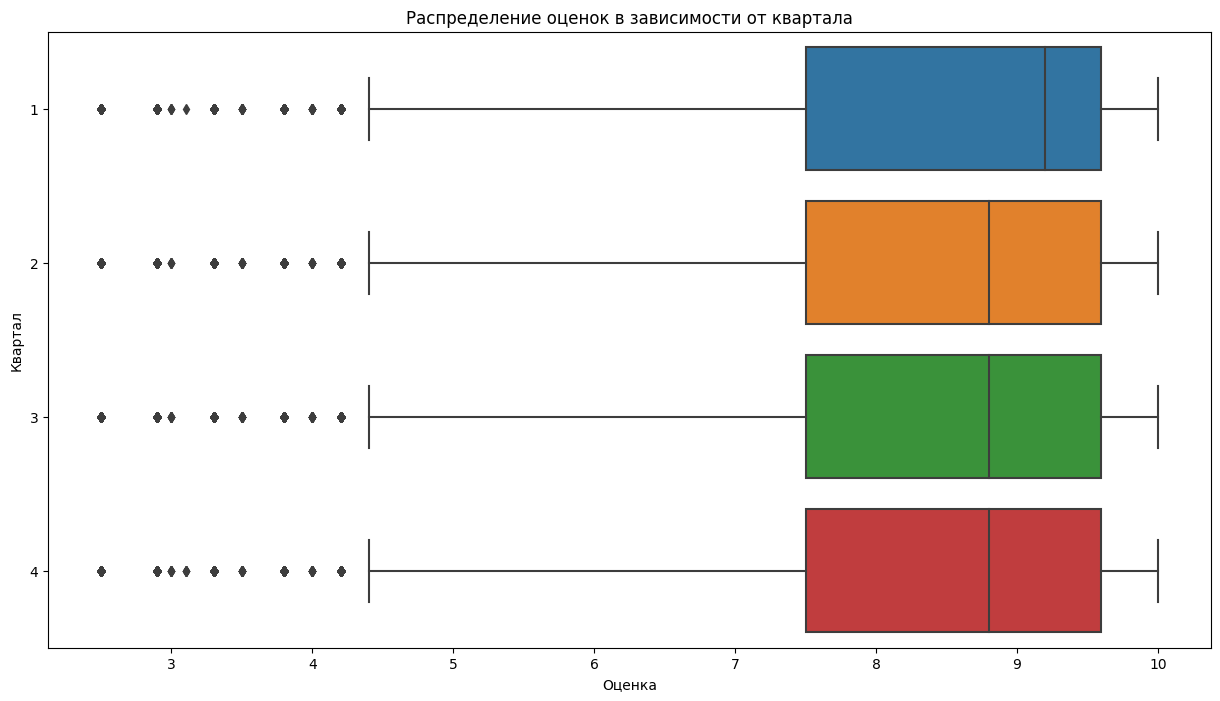

In [219]:
plt.figure(figsize=(15,8))
sns.boxplot(
    data = hotel[hotel['sample'] == 1],
    x='reviewer_score',
    y='quarter',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от квартала')
plt.xlabel('Оценка')
plt.ylabel('Квартал')
plt.show()

Видно, что отличие в оценках идет для первого квартала. Возможно на это влияет новогодние каникулы и начало нового года. У людей может быть более приподнятое настроение) Думаю взять для обучения только признак квартала.

# Отзыв

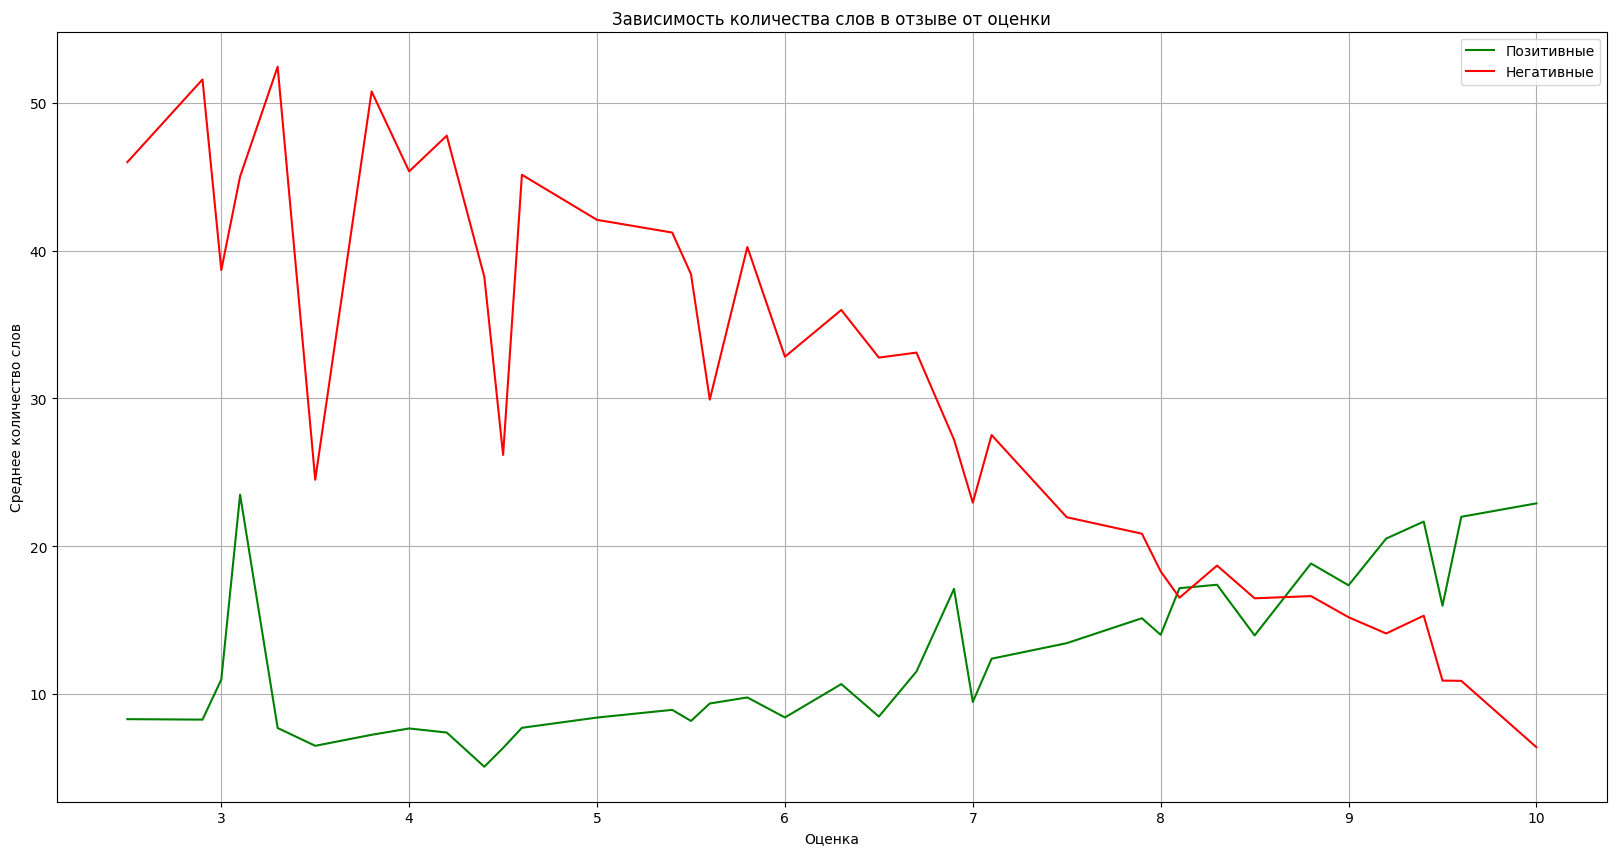

In [220]:
# Маска
filtered_data = hotel[hotel['sample'] == 1]

# Создание pivot table для среднего количества слов в отзывах по оценке и типу отзыва
pivot_table = filtered_data.pivot_table(index='reviewer_score', 
                                        values=['review_total_positive_word_counts', 'review_total_negative_word_counts'], 
                                        aggfunc='mean')

plt.figure(figsize=(20,10))
plt.plot(pivot_table.index,
         pivot_table['review_total_positive_word_counts'],
         color='green',
         label='Позитивные')
plt.plot(pivot_table.index,
         pivot_table['review_total_negative_word_counts'],
         color='red',
         label='Негативные')
plt.legend()
plt.xlabel('Оценка')
plt.ylabel('Среднее количество слов')
plt.title('Зависимость количества слов в отзыве от оценки')
plt.grid(True)
plt.show()

In [221]:
hotel[['negative_review','review_total_negative_word_counts','positive_review', 'review_total_positive_word_counts']].describe(include='object')

,negative_review,positive_review
count,515738,515738
unique,330011,412601
top,No Negative,No Positive
freq,127890,35946


Создадим признак - разница между положительными словами и отрицательными:

In [222]:
hotel['positive_to_negative_diff'] = hotel['review_total_positive_word_counts'] - hotel['review_total_negative_word_counts']

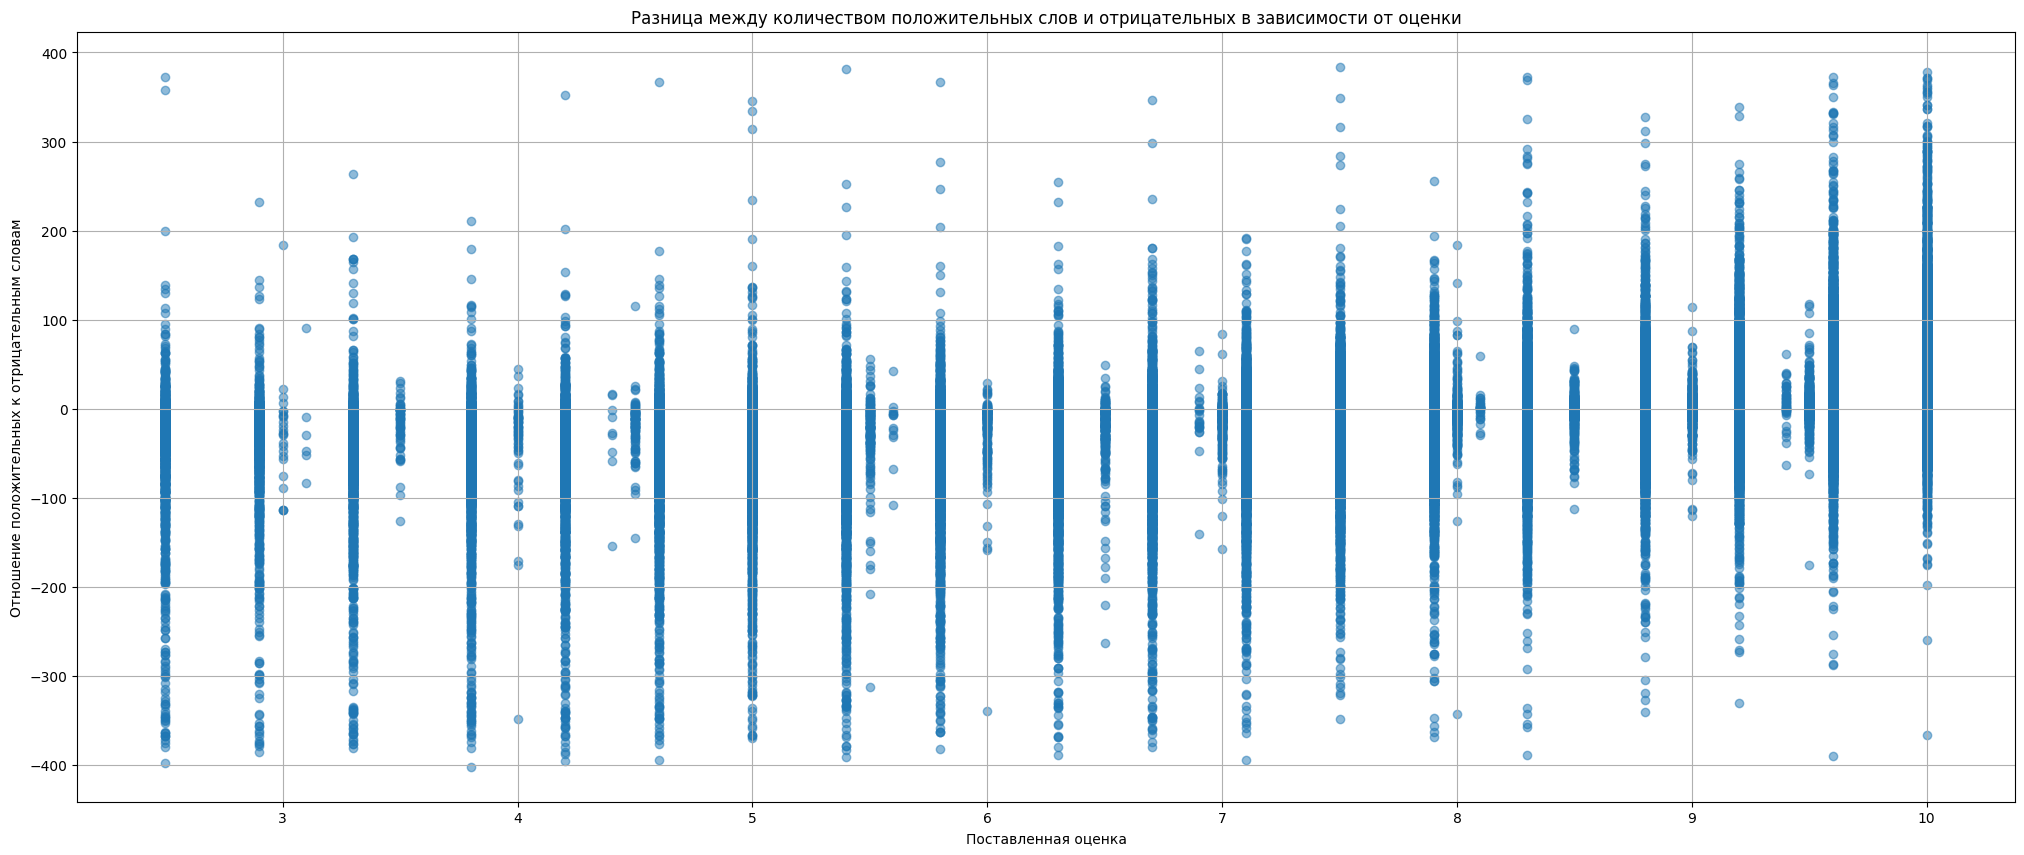

In [223]:
plt.figure(figsize=(25, 10))

plt.scatter(hotel['reviewer_score'][hotel['sample'] == 1],
            hotel['positive_to_negative_diff'][hotel['sample'] == 1],
            alpha=0.5)
plt.xlabel('Поставленная оценка')
plt.ylabel('Отношение положительных к отрицательным словам')
plt.title('Разница между количеством положительных слов и отрицательных в зависимости от оценки')
plt.grid(True)
plt.show()

Наиболее встречающиеся отзывы это No Negative, No Positive. Количество слов в таких отзывах равно 0. Тогда как в развернутых ответах количество слов в столбцах 'review_total_negative_word_counts', 'review_total_positive_word_counts' отличается от фактических на 1 или 2 слова. Не думаю, что это критично, для модели. Также чаще всего люди пишут больше негативного, даже если ставят высокую оценку, они подробно распишут, что им не понравилось.

Также я обратила внимание, что есть несколько отзывов с большим положительным отзывом, но оценку ставят низкую. Посмотрев эти записи, можно сказать, что люди просто перепутали поля и написали в положительном поле свой отрицательный опыт. 
Есть отзывы, где люди всем довольны, но оценку ставят среднюю, но делают это скорее всего осознанно

Я думаю отзыв - это важный фактор при приогнозировании оценки. Попробуем оценить тональность текста при помощи NLTK.

Так как no positive имеет отрицательный смысл, но анализатор текста воспримет слово'positive' как положительное, то заменим No Negative -  на Positive и наоборот.

In [224]:
hotel['negative_review'] = hotel['negative_review'].apply(
    lambda x: x.replace('No Negative', 'Positive'))
hotel['positive_review'] = hotel['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

In [225]:
def sent_analize_neg(row):
    sent_dict = sent_analyzer.polarity_scores(row['negative_review'])
    row['neg_pos_rev'] = sent_dict['pos']
    row['neg_neg_rev'] = sent_dict['neg']
    row['neg_neu_rev'] = sent_dict['neu']
    row['neg_compound_rev'] = sent_dict['compound']
    return row

In [226]:
def sent_analize_pos(row):
    sent_dict = sent_analyzer.polarity_scores(row['positive_review'])
    row['pos_pos_rev'] = sent_dict['pos']
    row['pos_neg_rev'] = sent_dict['neg']
    row['pos_neu_rev'] = sent_dict['neu']
    row['pos_compound_rev'] = sent_dict['compound']
    return row

In [227]:
hotel = hotel.apply(sent_analize_neg, axis=1)
hotel = hotel.apply(sent_analize_pos, axis=1)

# Национальность

In [228]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 33 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               515738 non-null  object        
 1   additional_number_of_scoring                515738 non-null  int64         
 2   review_date                                 515738 non-null  datetime64[ns]
 3   average_score                               515738 non-null  float64       
 4   hotel_name                                  515738 non-null  object        
 5   reviewer_nationality                        515738 non-null  object        
 6   negative_review                             515738 non-null  object        
 7   review_total_negative_word_counts           515738 non-null  int64         
 8   total_number_of_reviews                     515738 non-null  int64        

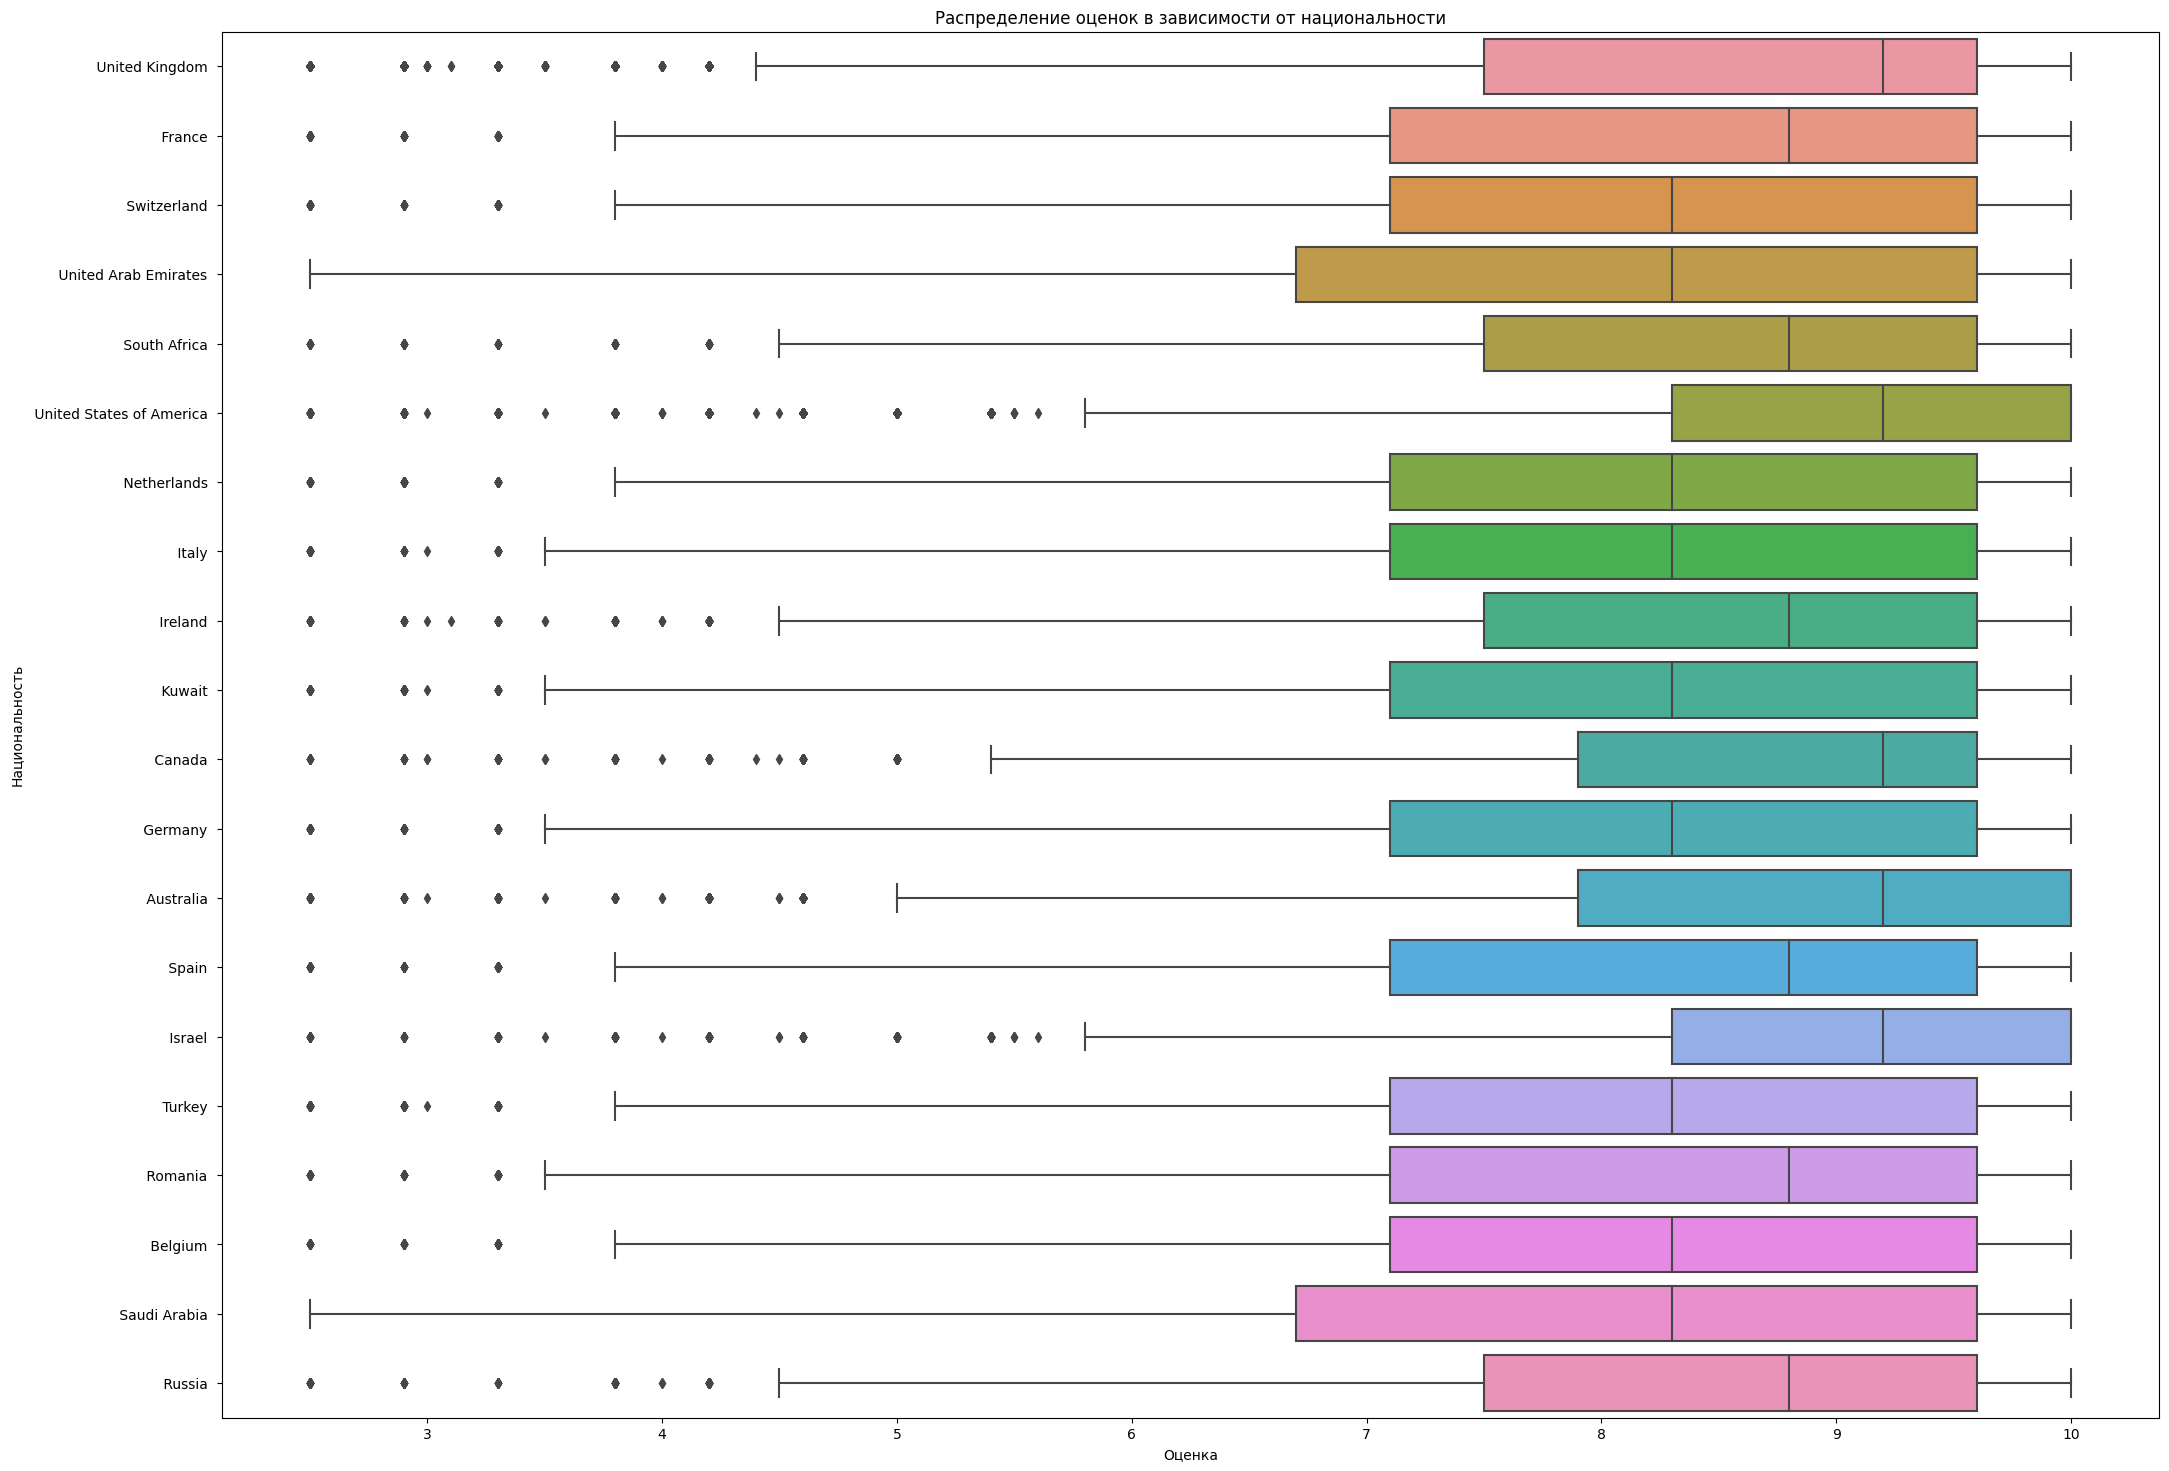

In [229]:
# Маска
filtered_data = hotel[hotel['sample'] == 1]

top_20_nationalities = filtered_data['reviewer_nationality'].value_counts().nlargest(20).index
plt.figure(figsize=(25,18))
sns.boxplot(
    data = filtered_data[filtered_data['reviewer_nationality'].isin(top_20_nationalities)],
    x='reviewer_score',
    y='reviewer_nationality',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от национальности')
plt.xlabel('Оценка')
plt.ylabel('Национальность')
plt.show()

Всего в датасете представлено 227 национальностей. Средняя оценка меняется в зависимости от национальности. Возможно, разные культурные, социальные или экономические факторы могут влиять на их восприятие услуг отеля.

Выделим 5 самых крупных из них, а затем закодируем.

In [230]:
nationality_top5 = list(hotel['reviewer_nationality'].value_counts().nlargest(5).index)

In [231]:
hotel['reviewer_nationality'] = hotel['reviewer_nationality'].apply(lambda x: x if x in nationality_top5 else 'Other')

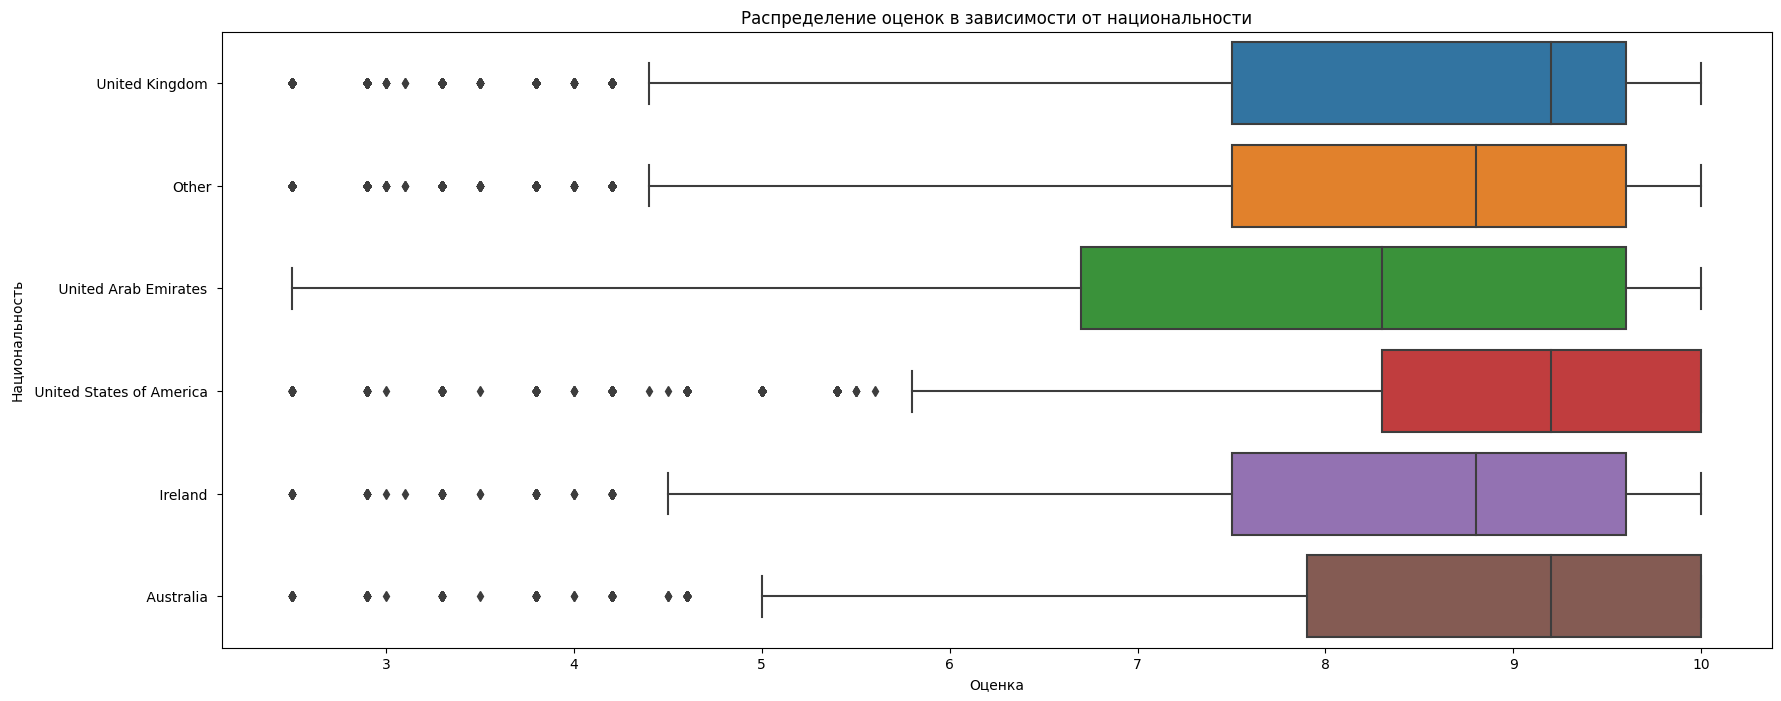

In [232]:
plt.figure(figsize=(20,8))
sns.boxplot(
    data = hotel[hotel['sample'] == 1],
    x='reviewer_score',
    y='reviewer_nationality',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от национальности')
plt.xlabel('Оценка')
plt.ylabel('Национальность')
plt.show()

# Теги

In [233]:
hotel['tags'].head(5)

0    [' Leisure trip ', ' Couple ', ' Double Room '...
1    [' Leisure trip ', ' Group ', ' Triple Room ',...
2    [' Business trip ', ' Solo traveler ', ' Twin ...
3    [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4    [' Business trip ', ' Solo traveler ', ' Class...
Name: tags, dtype: object

In [234]:
# Создаем функцию извлечения тега
def extract_tags(tags_string):
    return list(tag.strip(" '[]") for tag in tags_string.split(','))

# Применяем функцию к столбцу 'tags' и обновляем список тегов
hotel['tags'] = hotel['tags'].apply(lambda x: extract_tags(x))

hotel['tags'].head(5)

0    [Leisure trip, Couple, Double Room, Stayed 2 n...
1    [Leisure trip, Group, Triple Room, Stayed 1 ni...
2    [Business trip, Solo traveler, Twin Room, Stay...
3    [Leisure trip, Couple, Ambassador Junior Suite...
4    [Business trip, Solo traveler, Classic Double ...
Name: tags, dtype: object

In [235]:
hotel['tags'].explode().value_counts().nlargest(15)

tags
Leisure trip                      417778
Submitted from a mobile device    307640
Couple                            252294
Stayed 1 night                    193645
Stayed 2 nights                   133937
Solo traveler                     108545
Stayed 3 nights                    95821
Business trip                      82939
Group                              65392
Family with young children         61015
Stayed 4 nights                    47817
Double Room                        35207
Standard Double Room               32248
Superior Double Room               31393
Family with older children         26349
Name: count, dtype: int64

In [236]:
hotel['tags'].apply(lambda x: len(x)).max()

6

Всего максимальное количество тегов к проживанию 6, т.е. 6 типов. Чтобы найти все возможные значения для каждого типа тега пройдемся по датафрему с полными шестью тегами:

In [237]:
tags_6_length = hotel[hotel['tags'].apply(lambda x: len(x)) == 6]['tags']

In [238]:
# Списки для создания тегов по каждому типу
with_a_pet = []
trip_type = []
travelers = []
room_type = []
nights_stayed = []
device_used = []

# Получаем уникальные значения для каждой позиции в списке тегов
unique_tags_by_position = [set([tags[i] for tags in tags_6_length]) for i in range(6)]

# Выводим уникальные значения для каждой позиции
for i, unique_tags in enumerate(unique_tags_by_position):
    print(f"Уникальные значения для позиции {i+1}:")
    print(unique_tags)
    if i == 0:
        with_a_pet.extend(list(unique_tags))
    elif i == 1:
        trip_type.extend(list(unique_tags))
    elif i == 2:
        travelers.extend(list(unique_tags))
    elif i == 3:
        room_type.extend(list(unique_tags))
    elif i == 4:
        nights_stayed.extend(list(unique_tags))
    elif i == 5:
        device_used.extend(list(unique_tags))

    print()

Уникальные значения для позиции 1:
{'With a pet'}

Уникальные значения для позиции 2:
{'Leisure trip', 'Business trip'}

Уникальные значения для позиции 3:
{'Family with older children', 'Couple', 'Solo traveler', 'Group', 'Family with young children'}

Уникальные значения для позиции 4:
{'Deluxe Junior Suite', 'Large Double Room', 'Studio', 'Suite', 'Club Double Room', 'One Bedroom Suite', 'Special Offer Double Room', 'Executive Triple Room', 'Special Offer Double or Twin Room', 'Premium Room 2 Adults', 'Studio Apartment', 'Superior Double or Twin Room with City View', 'Deluxe King Room', 'Classic Double Room', 'Comfort Double or Twin Room', 'Duplex Double Room', 'Sextuple Room', 'X Ordinary Room', 'Standard Room with Queen Bed', 'Standard Quadruple Room', 'Standard Queen or Twin Room Lower Ground Floor', 'Superior Double Room with Spa Access', 'Comfort Triple Room', 'Standard Twin Room', 'Twin Hilton Guest Room', 'Superior Twin Room with Park View', 'Superior Room', 'Family Room with

In [239]:
other = []
all_tags = set(tag for tags in hotel['tags'] for tag in tags)
for tag in all_tags:
    if tag in with_a_pet or tag in trip_type or tag in travelers or tag in room_type or tag in nights_stayed or tag in device_used:
        pass
    elif tag.startswith('Stayed'):
        nights_stayed.append(tag)
    else:
        other.append(tag)

Чтобы не пропустить какие-либо уникальные значения для каждого типа тега, мы пройдемся по первым тегам всего датасета. В общей массе тегов типов комнат трудно их заметить, но первые теги именно это и представляют.

Потеряли 'Travelers with friends'

In [240]:
travelers.append('Travelers with friends')
other.remove('Travelers with friends')
room_type.extend(other)

In [241]:
print(len(room_type))
print(with_a_pet)
print(trip_type)
print(travelers)
print(nights_stayed)
print(device_used)

2387
['With a pet']
['Leisure trip', 'Business trip']
['Family with older children', 'Couple', 'Solo traveler', 'Group', 'Family with young children', 'Travelers with friends']
['Stayed 14 nights', 'Stayed 4 nights', 'Stayed 3 nights', 'Stayed 11 nights', 'Stayed 10 nights', 'Stayed 6 nights', 'Stayed 20 nights', 'Stayed 18 nights', 'Stayed 5 nights', 'Stayed 9 nights', 'Stayed 8 nights', 'Stayed 1 night', 'Stayed 7 nights', 'Stayed 2 nights', 'Stayed 29 nights', 'Stayed 13 nights', 'Stayed 22 nights', 'Stayed 15 nights', 'Stayed 30 nights', 'Stayed 23 nights', 'Stayed 24 nights', 'Stayed 12 nights', 'Stayed 17 nights', 'Stayed 31 nights', 'Stayed 27 nights', 'Stayed 21 nights', 'Stayed 25 nights', 'Stayed 19 nights', 'Stayed 28 nights', 'Stayed 16 nights', 'Stayed 26 nights']
['Submitted from a mobile device']


In [242]:
#Функция кодирования тега проживания с животным
def pets_tag(row):
    if 'With a pet' in row:
        row.remove('With a pet')
        return 1
    else:
        return 0

hotel['tag_pets'] = hotel['tags'].apply(pets_tag)

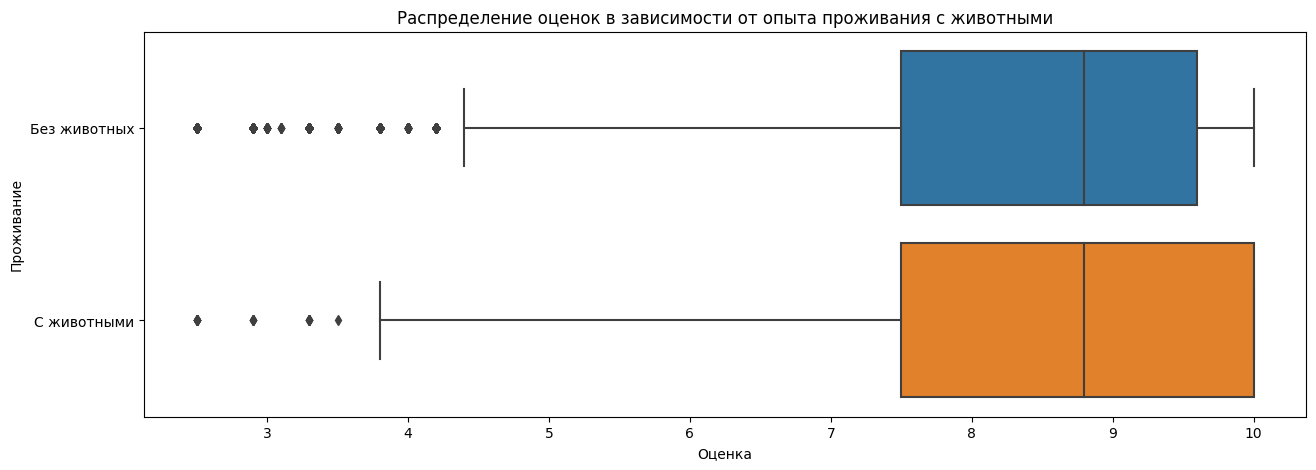

In [243]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data = hotel[hotel['sample'] == 1],
    x='reviewer_score',
    y='tag_pets',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от опыта проживания с животными')
plt.xlabel('Оценка')
plt.ylabel('Проживание')
plt.yticks([0, 1], ['Без животных', 'С животными'])
plt.show()

Средняя оценка не меняется и думаю этот признак не особо важжен в прогнозировании.

In [244]:
#Функция кодирования тега отправлено с мобильного устройства
def device(row):
    if 'Submitted from a mobile device' in row:
        row.remove('Submitted from a mobile device')
        return 1
    else:
        return 0

hotel['tag_mobile_device'] = hotel['tags'].apply(device)

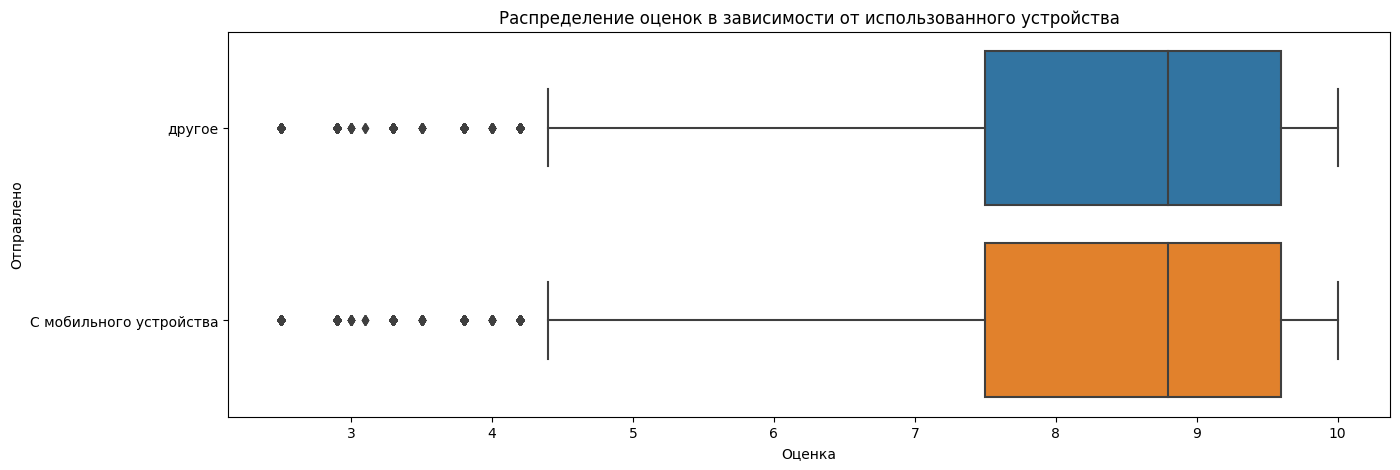

In [245]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data = hotel[hotel['sample'] == 1],
    x='reviewer_score',
    y='tag_mobile_device',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от использованного устройства')
plt.xlabel('Оценка')
plt.ylabel('Отправлено')
plt.yticks([0, 1], ['другое', 'С мобильного устройства'])
plt.show()

Думаю тоже этот признак не особо важен

In [246]:
#Функция определения тега Рабочая поездка или Отдых
def type_trip_tag(row):
    if 'Leisure trip' in row:
        row.remove('Leisure trip')
        return 'Leisure trip'
    elif 'Business trip' in row:
        row.remove('Business trip')
        return 'Business trip'
    else:
        return None

In [247]:
hotel['tag_type_trip'] = hotel['tags'].apply(type_trip_tag)

In [248]:
hotel['tag_type_trip'].value_counts()

tag_type_trip
Leisure trip     417778
Business trip     82939
Name: count, dtype: int64

    Большинство отзывов с отдыха, нежели с рабочей поездки. Люди путешествующие по работе ставят в среднем оценку ниже, чем на отдыхе. Скорее всего они могут испытывать больший уровень стресса из-за работы, сроков и обязательств, что может повлиять на их восприятие и удовлетворенность услугами отеля. А также в отличие от отпуска, когда люди могут расслабиться и провести время так, как им нравится, на рабочих поездках времени на отдых может быть недостаточно. Это может привести к чувству усталости и раздражения, что отразится на оценке услуг отеля. Думаю это полезный показатель для обучения.

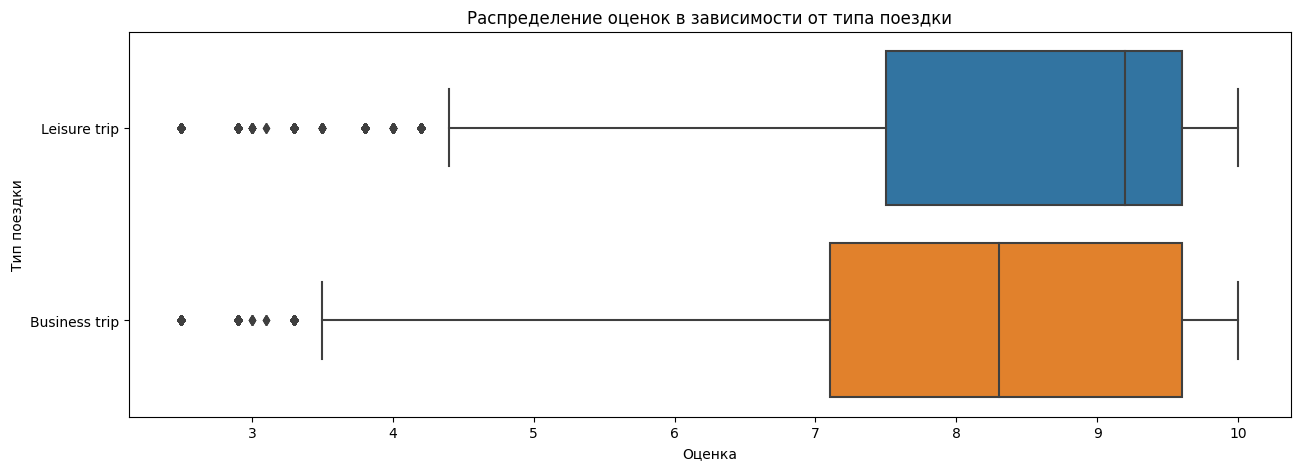

In [249]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data = hotel[hotel['sample'] == 1],
    x='reviewer_score',
    y='tag_type_trip',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от типа поездки')
plt.xlabel('Оценка')
plt.ylabel('Тип поездки')
plt.show()

In [250]:
hotel['tag_type_trip'].isnull().sum()

15021

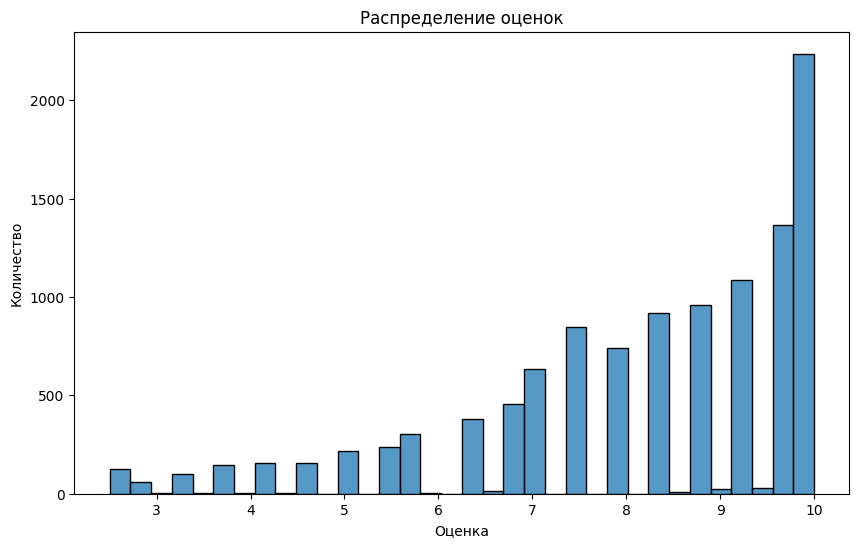

In [251]:
mask_null_type = hotel['tag_type_trip'].isnull()
plt.figure(figsize=(10, 6))
sns.histplot(data=hotel[(hotel['sample'] == 1) & mask_null_type], x='reviewer_score')

plt.title('Распределение оценок')
plt.xlabel('Оценка')
plt.ylabel('Количество')

plt.show()

Для 15021 строк нет записи о типе поездки. Заменим их наиболее встречающимся Leisure trip 

In [252]:
hotel['tag_type_trip'] = hotel['tag_type_trip'].fillna('Leisure trip')

In [253]:
def type_travelers(row):
    if 'Group' in row:
        row.remove('Group')
        return 'Group'
    elif 'Family with young children' in row:
        row.remove('Family with young children')
        return 'Family with young children'
    elif 'Solo traveler' in row:
        row.remove('Solo traveler')
        return 'Solo traveler'
    elif 'Couple' in row:
        row.remove('Couple')
        return 'Couple'
    elif 'Family with older children' in row:
        row.remove('Family with older children')
        return 'Family with older children'
    elif 'Travelers with friends' in row:
        row.remove('Travelers with friends')
        return 'Travelers with friends'
    else:
        return None

In [300]:
hotel['tag_travelers'] = hotel['tags'].apply(type_travelers)

KeyError: 'tags'

In [255]:
hotel['tag_travelers'].isnull().sum() #пропущенных значений о типе туристов нет

0

In [299]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data = hotel[hotel['sample'] == 1],
    x='reviewer_score',
    y='tag_travelers',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от группы туристов')
plt.xlabel('Оценка')
plt.ylabel('Группа туристов')
plt.show()

ValueError: Could not interpret input 'tag_travelers'

<Figure size 1500x500 with 0 Axes>

In [256]:
#Функция определения тега количества ночей:
def night_stayed(row):
    for tag in row:
        if tag.startswith('Stayed'):
            count_nights = int(tag.split()[1])
            row.remove(tag)
            return count_nights
    return None

In [257]:
hotel['tag_nights_stayed'] = hotel['tags'].apply(night_stayed)

In [258]:
hotel['tag_nights_stayed'].value_counts()

tag_nights_stayed
1.0     193645
2.0     133937
3.0      95821
4.0      47817
5.0      20845
6.0       9776
7.0       7399
8.0       2502
9.0       1293
10.0       889
11.0       418
12.0       316
14.0       247
13.0       246
15.0       117
16.0        57
17.0        42
18.0        33
19.0        29
21.0        23
20.0        19
27.0        11
30.0        11
23.0        10
22.0        10
25.0         7
26.0         7
28.0         7
24.0         6
29.0         5
31.0         1
Name: count, dtype: int64

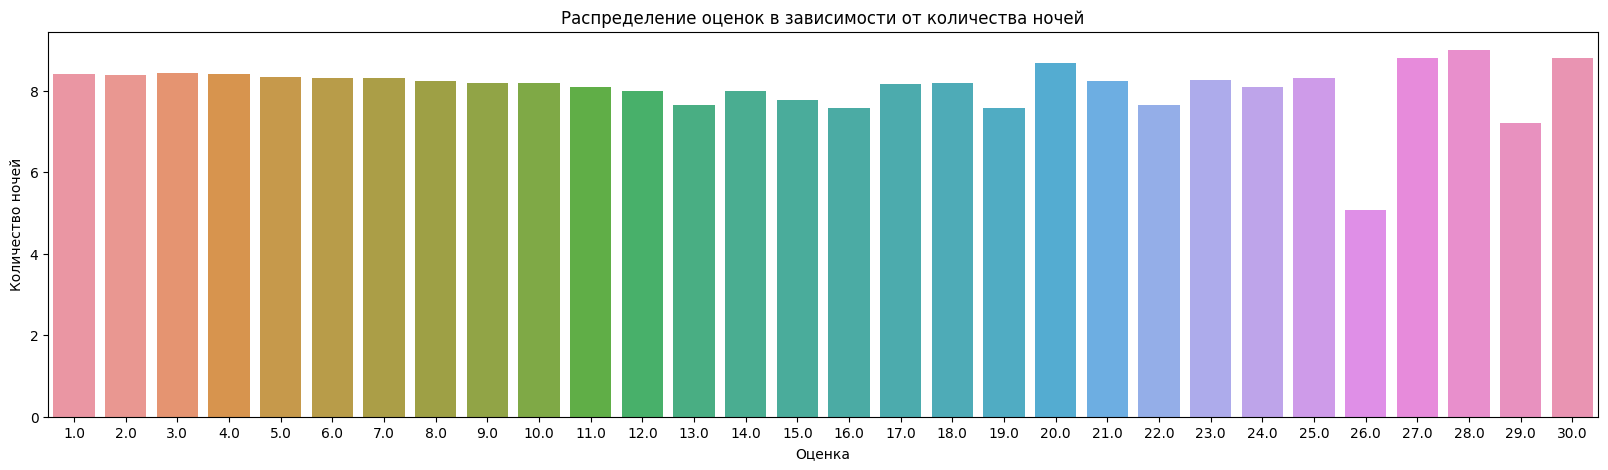

In [259]:
fig_nights = hotel[hotel['sample'] == 1].groupby('tag_nights_stayed')['reviewer_score'].mean().reset_index()

plt.figure(figsize=(20,5))
sns.barplot(data=fig_nights, x='tag_nights_stayed', y='reviewer_score')
plt.title('Распределение оценок в зависимости от количества ночей')
plt.xlabel('Оценка')
plt.ylabel('Количество ночей')
plt.show()

Люди чаще всего останавливаются на 1-5 ночей, потому что в датасете представлены столицы городов, а не курортные города, куда люди приезжают на длительный отдых. С прибавлением срока пребыввания в городе, чаще появляются низкие оценки. Туристы успевают заметить недостатки за это время и отражают это в отзывах.

In [260]:
hotel['tag_nights_stayed'].isnull().sum()

192

Для 192 записи пропущена длительность пребывания. Заполним их средними значениями

In [261]:
hotel['tag_nights_stayed'].fillna(round(hotel['tag_nights_stayed'].mean()), inplace=True)

В списках остались только теги, обозначающие тип комнат, выделим их и посмотрим есть ли пропущенные значения:

In [262]:
hotel['tags'] = hotel['tags'].explode()

In [263]:
hotel['tags'].isnull().sum()

192

Пропущенных тегов о типе комнаты совпадают с пропущенными значениями количества ночей. Возможно был какой-то сбой при выгрузке тегов и количество ночей вместе с типом комнат не были выгружены. Тип комнат закодируем пятью самыми популярными.

In [264]:
def room_type(row):
    important_rooms =['Double Room', 'Standard Double Room', 'Superior Double Room', 'Deluxe Double Room', 'Double or Twin Room']
    if row in important_rooms:
        return row
    elif pd.isna(row):
        return 'Other'
    else:
        return "Other"

In [265]:
hotel['tag_room_type'] = hotel['tags'].apply(room_type)

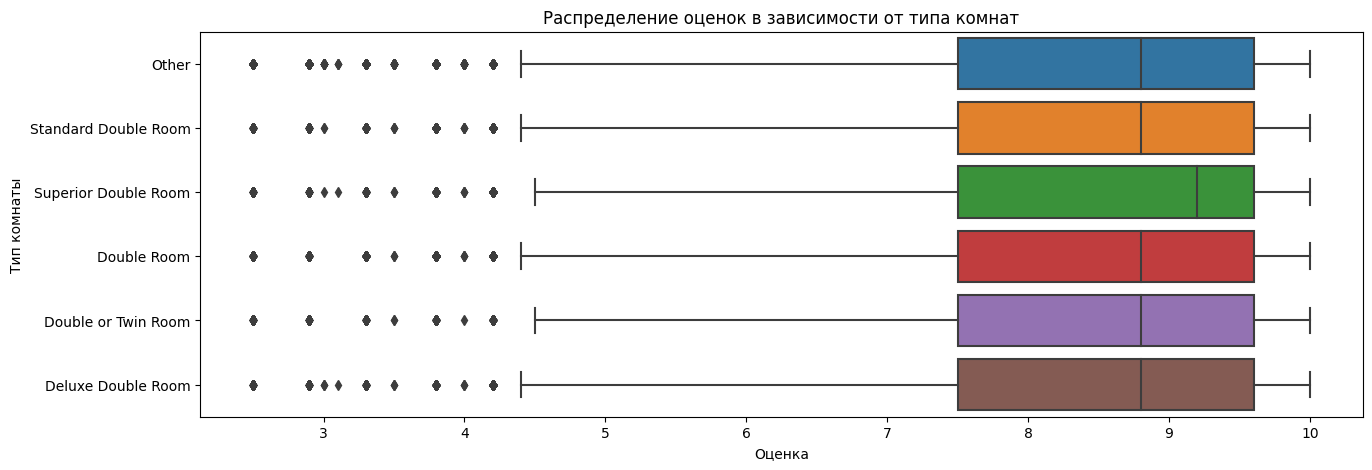

In [266]:
plt.figure(figsize=(15,5))
sns.boxplot(
    data = hotel[hotel['sample'] == 1],
    x='reviewer_score',
    y='tag_room_type',
    orient = 'h'
)
plt.title('Распределение оценок в зависимости от типа комнат')
plt.xlabel('Оценка')
plt.ylabel('Тип комнаты')
plt.show()

In [267]:
# Выделим колонки для кодирования:
cat_columns=['reviewer_nationality', 'country', 'tag_type_trip', 'tag_travelers', 'tag_room_type']

In [268]:
hotel[cat_columns] = hotel[cat_columns].astype('category')


In [269]:
onehot_encoder = OneHotEncoder(cols=cat_columns, use_cat_names=True)
hotel = onehot_encoder.fit_transform(hotel)

In [270]:
# удалим ненужные столбцы
columns_to_drop = ['hotel_address', 'review_date', 'hotel_name', 'negative_review', 'positive_review', 'tags', 'lat', 'lng', 'city', 'month', 'year']

In [271]:
hotel.drop(columns_to_drop, inplace=True, axis=1)

In [274]:
num_cols = ['additional_number_of_scoring', 'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'positive_to_negative_diff', 'pos_pos_rev', 'pos_neg_rev', 'pos_neu_rev',
       'pos_compound_rev', 'neg_pos_rev', 'neg_neg_rev', 'neg_neu_rev',
       'neg_compound_rev', 'tag_nights_stayed']

''

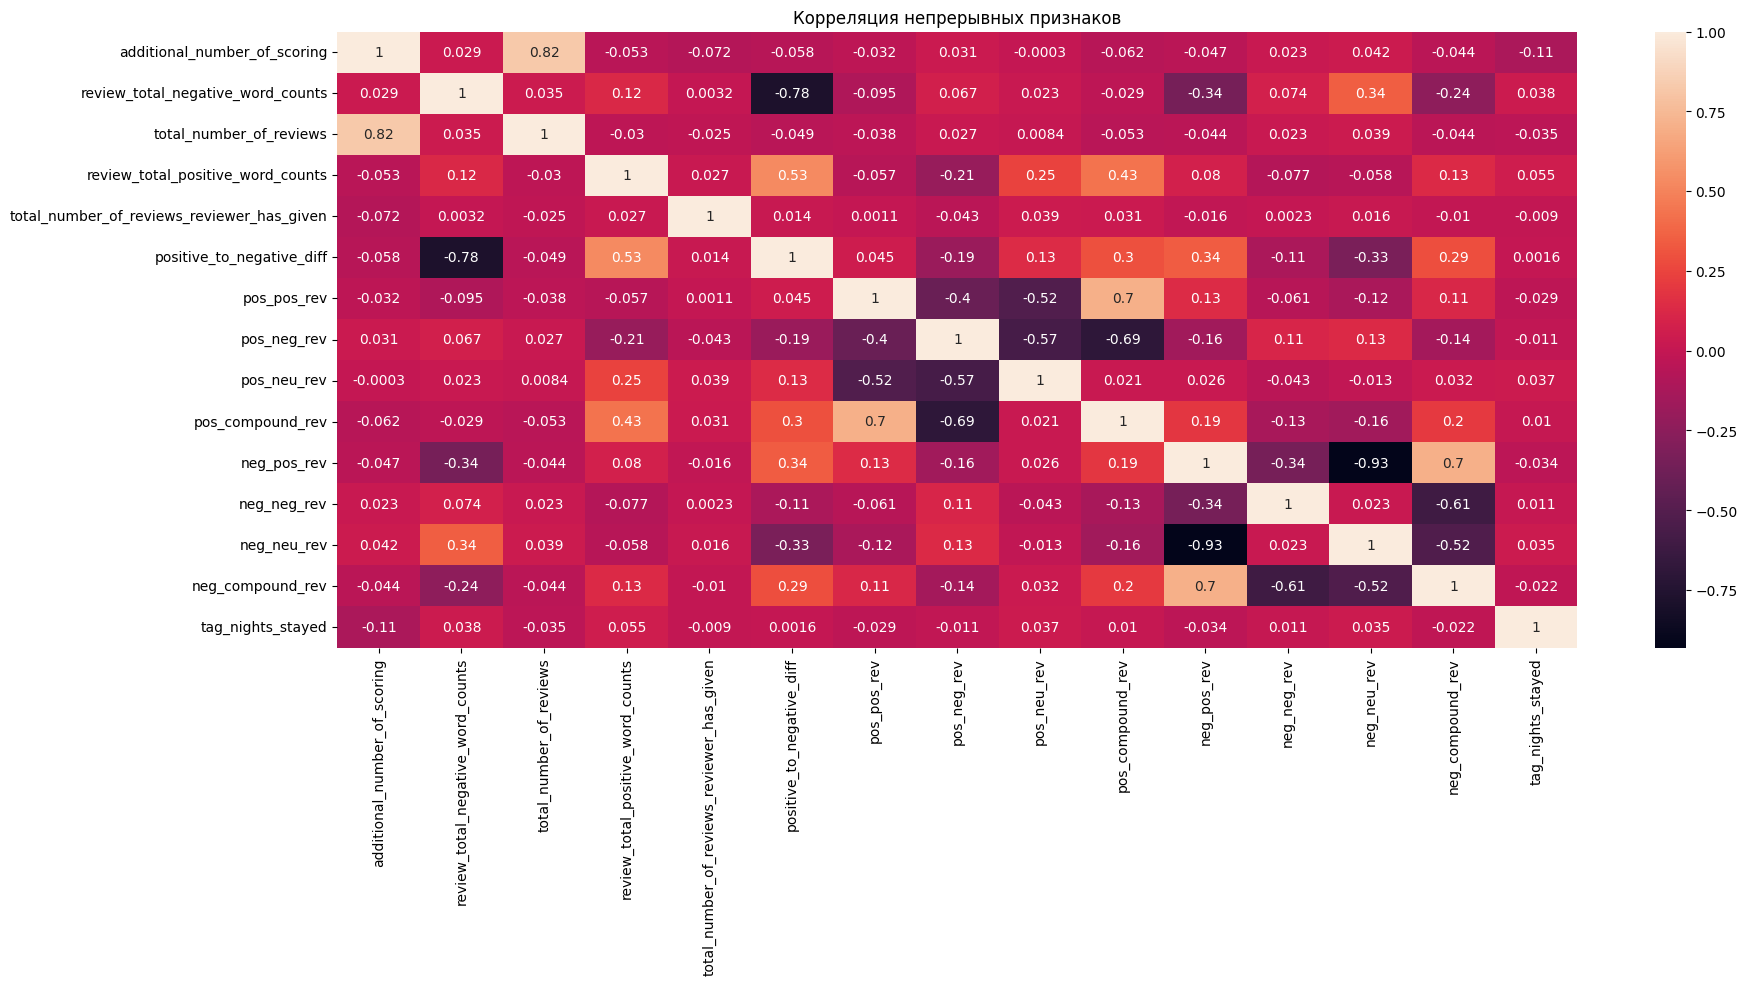

In [296]:
corr = hotel[num_cols].corr()

plt.figure(figsize=(20,8))
sns.heatmap(corr, annot=True)
plt.title('Корреляция непрерывных признаков')
;

In [276]:
cat_cols = ['average_score', 'reviewer_nationality_ United Kingdom ', 'reviewer_nationality_Other',
       'reviewer_nationality_ United Arab Emirates ',
       'reviewer_nationality_ United States of America ',
       'reviewer_nationality_ Ireland ', 'reviewer_nationality_ Australia ', 'country_United Kingdom', 'country_France',
       'country_Netherlands', 'country_Italy', 'country_Austria',
       'country_Spain', 'distance_to_center', 'quarter', 'tag_pets', 'tag_mobile_device',
       'tag_type_trip_Leisure trip', 'tag_type_trip_Business trip',
       'tag_travelers_Couple', 'tag_travelers_Solo traveler',
       'tag_travelers_Family with young children', 'tag_travelers_Group',
       'tag_travelers_Family with older children',
       'tag_travelers_Travelers with friends', 'tag_room_type_Other', 'tag_room_type_Standard Double Room',
       'tag_room_type_Superior Double Room', 'tag_room_type_Double Room',
       'tag_room_type_Double or Twin Room',
       'tag_room_type_Deluxe Double Room']

''

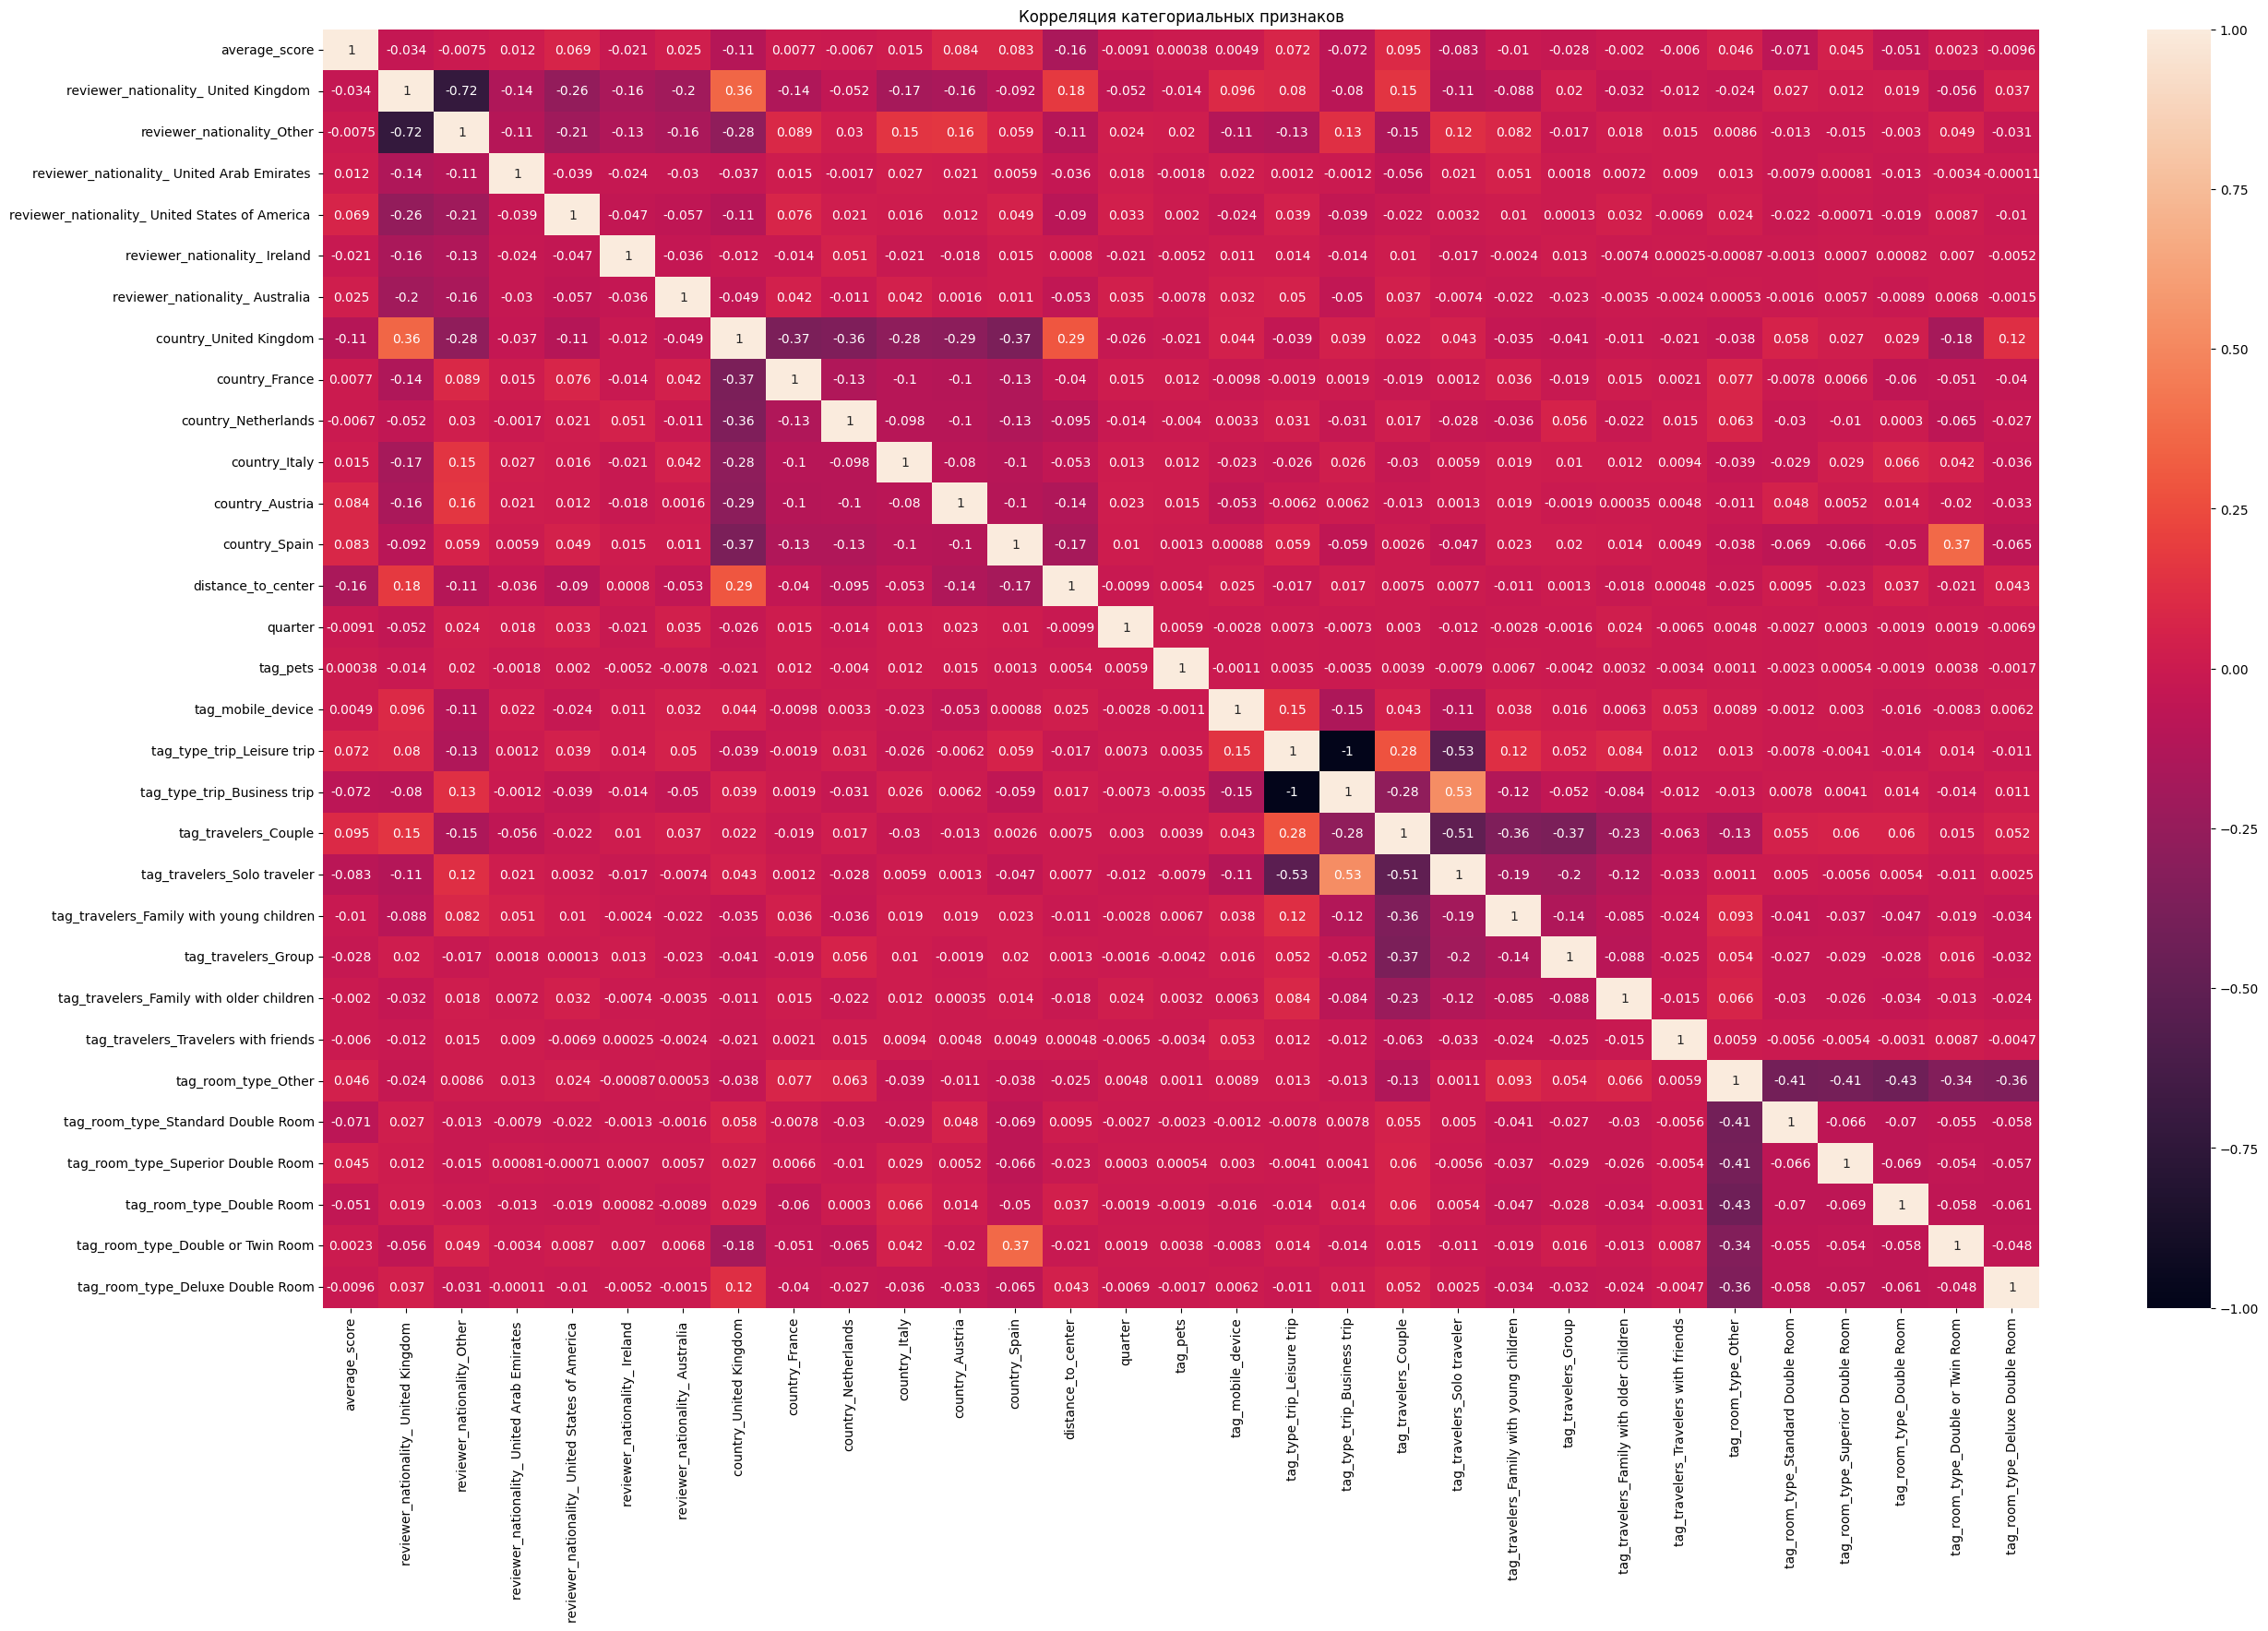

In [295]:
corr = hotel[cat_cols].corr()

plt.figure(figsize=(30,18))
sns.heatmap(corr, annot=True)
plt.title('Корреляция категориальных признаков')
;

In [278]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 49 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   additional_number_of_scoring                     515738 non-null  int64  
 1   average_score                                    515738 non-null  float64
 2   reviewer_nationality_ United Kingdom             515738 non-null  int64  
 3   reviewer_nationality_Other                       515738 non-null  int64  
 4   reviewer_nationality_ United States of America   515738 non-null  int64  
 5   reviewer_nationality_ Ireland                    515738 non-null  int64  
 6   reviewer_nationality_ Australia                  515738 non-null  int64  
 7   reviewer_nationality_ United Arab Emirates       515738 non-null  int64  
 8   review_total_negative_word_counts                515738 non-null  int64  
 9   total_number_of

In [279]:
# теперь выделим тестовую часть
train_data = hotel[hotel['sample'] == 1].drop(['sample'], axis=1)
test_data = hotel[hotel['sample'] == 0].drop(['sample'], axis=1)

y = train_data.reviewer_score.values
X = train_data.drop(['reviewer_score'], axis=1)

In [280]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [285]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 48), (386803, 48), (386803, 47), (309442, 47), (77361, 47))

In [282]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [283]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [284]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.9min finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.5s finished


In [286]:
# Получение средней абсолютной ошибки
def mean_absolute_percentage_error(y_tr, y_pr):
    y_tr, y_pr = np.array(y_tr), np.array(y_pr)
    return np.mean(np.abs((y_tr - y_pr) / y_tr)) * 100

print('MAPE:', round(mean_absolute_percentage_error(y_test, y_pred), 2))

MAPE: 12.5


<Axes: >

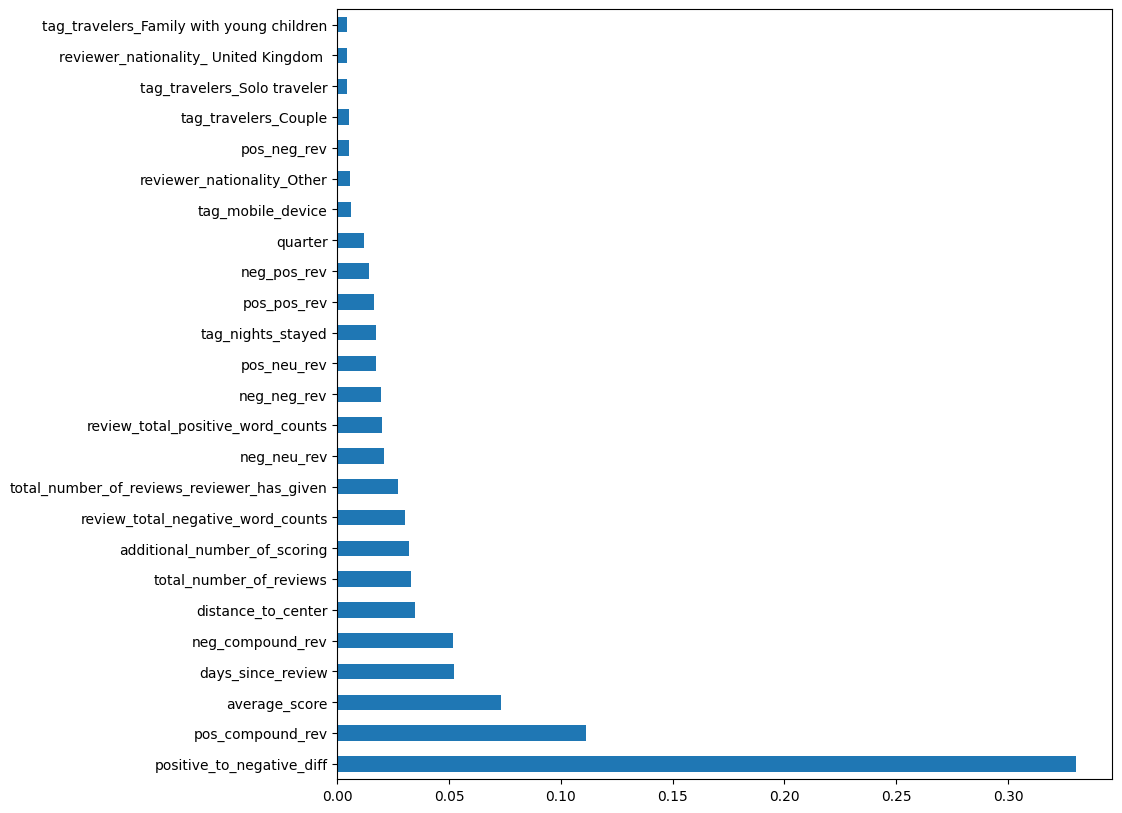

In [287]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(25).plot(kind='barh')

In [288]:
test_data.sample(10)

,additional_number_of_scoring,average_score,reviewer_nationality_ United Kingdom,reviewer_nationality_Other,reviewer_nationality_ United States of America,reviewer_nationality_ Ireland,reviewer_nationality_ Australia,reviewer_nationality_ United Arab Emirates,review_total_negative_word_counts,total_number_of_reviews,...,tag_travelers_Family with young children,tag_travelers_Family with older children,tag_travelers_Travelers with friends,tag_nights_stayed,tag_room_type_Double Room,tag_room_type_Other,tag_room_type_Double or Twin Room,tag_room_type_Superior Double Room,tag_room_type_Standard Double Room,tag_room_type_Deluxe Double Room
91786,111,8.1,1,0,0,0,0,0,16,1257,...,0,0,0,3.0,0,1,0,0,0,0
37704,82,9.3,0,1,0,0,0,0,0,532,...,0,0,0,1.0,0,1,0,0,0,0
124215,419,8.2,0,0,0,1,0,0,13,2968,...,0,0,0,2.0,0,1,0,0,0,0
18587,623,9.0,1,0,0,0,0,0,0,2750,...,0,0,0,1.0,0,1,0,0,0,0
34252,207,8.2,0,1,0,0,0,0,0,1164,...,0,0,0,2.0,0,0,0,0,1,0
44389,704,8.3,0,1,0,0,0,0,29,2443,...,0,0,0,2.0,0,1,0,0,0,0
55563,601,8.5,0,1,0,0,0,0,49,4032,...,0,0,0,3.0,0,1,0,0,0,0
12147,82,8.5,0,0,0,0,0,1,3,369,...,0,0,0,1.0,0,1,0,0,0,0
128848,160,8.1,1,0,0,0,0,0,6,1560,...,0,0,0,2.0,0,0,1,0,0,0
67344,198,9.4,0,0,0,0,0,1,37,1711,...,0,0,0,4.0,0,0,1,0,0,0


In [289]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [290]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [291]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.2s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    1.1s finished


In [297]:
predict_submission

''

In [293]:
list(sample_submission)

['reviewer_score', 'id']

In [294]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.604,488440
1,7.123,274649
2,8.203,374688
3,9.677,404352
4,9.437,451596
5,8.987,302161
6,7.677,317079
7,7.722,13963
8,8.135,159785
9,7.477,195089


**Вывод:** Удалось достичь MAPE в размере 12.5 с использованием анализа исследовательских данных (EDA). Основным признаком датасета, оказывающим влияние на модель, является текст отзыва. Значительное воздействие на модель оказывают также созданные признаки оценки тональности текста.

Интересно отметить, что нормализация признаков не оказала существенного влияния на итоговый MAPE, несмотря на то, что данные имели разный масштаб. А удаление незначительных признаков немного ухудшило результат.

Для улучшения результатов можно обратить внимание на следующие аспекты:

Работа с выбросами: Низкие оценки с большим количеством слов в положительном отзыве могут быть аномалиями, которые стоит рассмотреть отдельно и, возможно, исключить или обработать.
Работа с текстом отзывов: Дальнейшая обработка и анализ текстов отзывов может привести к выделению дополнительных признаков или улучшению признаков оценки тональности.